In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
from solver import deasolver

In [20]:
results = []
df_imp = pd.DataFrame()

In [6]:
df = pd.read_excel("Data/US12I1O.xlsx", index_col = 0)
df

Input 01  Input 02  Input 03  Input 04  Input 05  Input 06  \
DMU 0001    288.81    493.46    202.31    356.18    384.45    653.77   
DMU 0002    349.98    420.00    139.32    312.89    543.04    504.54   
DMU 0003    280.78    452.42    127.85    315.42    559.22    466.35   
DMU 0004    405.33    376.32    237.28    451.43    414.19    318.03   
DMU 0005    348.96    426.79    170.01    292.91    502.76    342.94   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    206.54    333.40    274.01    424.09    465.99    548.04   
DMU 0997    328.82    415.09    121.60    268.46    494.32    454.22   
DMU 0998    310.52    565.44    126.06    320.91    463.01    390.07   
DMU 0999    390.34    255.88    209.15    269.76    576.57    261.14   
DMU 1000    251.60    497.67    256.31    477.68    338.44    716.68   

          Input 07  Input 08  Input 09  Input 10  Input 11  Input 12  \
DMU 0001    129.40    100.28     38.45    306.59     92.41    250.91   
DMU 0002    120.43    177.65     86.96    330.87     79.16    201.81   
DMU 0003    166.57    165.57     81.43    359.75     83.23    246.78   
DMU 0004    187.77    154.65     49.71    316.82     97.74    344.70   
DMU 0005    146.53    165.78     63.80    329.79     76.17    355.61   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    143.02     58.25     49.65    355.16     85.54    238.49   
DMU 0997    150.96    143.44     65.04    374.88     69.81    261.57   
DMU 0998    151.81    202.55    101.67    333.12     87.52    328.13   
DMU 0999    162.39    102.92     66.70    401.16     72.50    318.26   
DMU 1000    158.12    157.51     37.08    273.94     91.51    296.31   

          Output 01  
DMU 0001     250.77  
DMU 0002     372.71  
DMU 0003     293.40  
DMU 0004     462.69  
DMU 0005     374.18  
...             ...  
DMU 0996     279.23  
DMU 0997     344.45  
DMU 0998     320.62  
DMU 0999     380.24  
DMU 1000     408.37  

[1000 rows x 13 columns]

In [14]:
def ml(df=df, sol_filepath="Data/Data12/US12I1O_Sol_0.xlsx", i=None):
    
    df_sol = pd.read_excel(sol_filepath, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    plt.figure(figsize=(18,12))
    sns.heatmap(df_weights.eq(0).transpose(),
            cmap="YlGnBu",
            cbar=False,
            cbar_kws={'label': 'Zero Values'});
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    xgb_model = xgb.XGBRegressor(random_state=42)

    pipe_xgb = make_pipeline(std_scaler, xgb_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())
    
    learning_rate = [0.01, 0.1, 0.2, 0.3]
    n_estimators = [100, 500, 1000]
    max_depth =  [3, 5, 6, 10, 15, 20]
    subsample = np.arange(0.5, 1.0, 0.1)
    colsample_bytree = np.arange(0.4, 1.0, 0.1)
    colsample_bylevel = np.arange(0.4, 1.0, 0.1)
    
    # specify parameter values to search
    params = {}
    params['xgbregressor__learning_rate'] = learning_rate
    params['xgbregressor__n_estimators'] = n_estimators
    params['xgbregressor__max_depth'] = max_depth
    params['xgbregressor__subsample'] = subsample
    params['xgbregressor__colsample_bytree'] = colsample_bytree
    params['xgbregressor__colsample_bylevel'] = colsample_bylevel
    
    grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
    df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
    input_imp = list(df_xgb.loc[df_xgb["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    fig = px.bar(df_xgb, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"XGBRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
    df_zero.index = [f.split('_')[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_xgb, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"XGBRegressor Feature Importance - Zero_Count Relationship",
    )

    fig.show()
    
    return pipe_xgb, results, y, df_merged

In [15]:
def plotScatter(res_xgb, x, y, colorCol, blueCount, redCount):

    fig = px.scatter(res_xgb, x=x, y=y, color = colorCol, color_discrete_map= {True:"blue", False: "red"},
                     hover_data=[x, y, colorCol] + [res_xgb.index])


    fig.add_traces(
        list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
    )

    fig.update_traces(line_color='lightgreen', line_width=3)

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"Efficiency Scores Comparison (Blue: {blueCount}, Red: {redCount})",
    )

    fig.show()

In [16]:
def compareML(pipe_xgb, y, X=df, err_thresh = 3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = pipe_xgb.fit(X_train, y_train.values.ravel())
    prediction = model.predict(X_test)
    
    res = pd.DataFrame()
    res["Prediction"] = pd.Series(prediction.ravel())
    res["Actual"] = y_test.values
    res["Diff"] = res.Prediction - res.Actual
    res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
    res[f"Error_Perc < {err_thresh}"] = np.abs(res["Error_Perc"]) < err_thresh  
    res = res.round(4)
    print("res: ", res)
    
    blue = res[f"Error_Perc < {err_thresh}"].sum()
    print("blue: ", blue)
    red = len(res[f"Error_Perc < {err_thresh}"]) - (res[f"Error_Perc < {err_thresh}"].sum())
    print("red: ", red)
    
    rho, p = stats.spearmanr(res.Prediction, res.Actual)
    print("rho:", rho.round(4)) 
    print("p-Value", p.round(4)) 
    
    plotScatter(res, x="Actual", y="Prediction", colorCol=f"Error_Perc < {err_thresh}",
               blueCount=blue, redCount=red)

In [17]:
def compareES(df_1_path=None, df_0_path=None, df_basic_path="Data/Data12/US12I1O_Sol_0.xlsx", err_thresh = 10):
    
    df_basic = pd.read_excel(df_basic_path, index_col=0)
    df_1 = pd.read_excel(df_1_path, index_col=0)
    
    res_xgb = pd.DataFrame()
    res_xgb["Efficiency_Scores_Basic"] = df_basic["Efficiency_Scores"]
    res_xgb["Efficiency_Scores_ML"] = df_1["Efficiency_Scores"]

    
    res_xgb["Diff_Basic"] = res_xgb["Efficiency_Scores_Basic"]  - res_xgb["Efficiency_Scores_ML"]
    res_xgb["Diff_Basic_Perc"] = (res_xgb["Diff_Basic"] / res_xgb["Efficiency_Scores_Basic"]) * 100 
    res_xgb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_xgb["Diff_Basic_Perc"]) < err_thresh
    
    res_xgb["Diff_Basic"] = res_xgb["Efficiency_Scores_Basic"]  - res_xgb["Efficiency_Scores_ML"]
    res_xgb["Diff_Basic_Perc"] = (res_xgb["Diff_Basic"] / res_xgb["Efficiency_Scores_Basic"]) * 100 
    res_xgb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_xgb["Diff_Basic_Perc"]) < err_thresh
    
    blue = res_xgb[f"Diff_Basic_Perc < {err_thresh}"].sum()
    print("blue : ", blue)
    red = len(res_xgb[f"Diff_Basic_Perc < {err_thresh}"]) - (res_xgb[f"Diff_Basic_Perc < {err_thresh}"].sum())
    print("red : ", red)
    
    res_xgb = res_xgb.round(4)
    
    plotScatter(res_xgb, x="Efficiency_Scores_Basic", y="Efficiency_Scores_ML", colorCol=f"Diff_Basic_Perc < {err_thresh}",
               blueCount=blue, redCount=red)
       
    if df_0_path:
        
        df_0 = pd.read_excel(df_0_path, index_col=0)
        res_xgb["Efficiency_Scores_ML_Pr"] = df_0["Efficiency_Scores"]
        
        res_xgb["Diff_Previous"] = res_xgb["Efficiency_Scores_ML_Pr"]  - res_xgb["Efficiency_Scores_ML"]
        res_xgb["Diff_Previous_Perc"] = (res_xgb["Diff_Previous"] / res_xgb["Efficiency_Scores_ML_Pr"]) * 100 
        res_xgb[f"Diff_Previous_Perc < {err_thresh}"] = np.abs(res_xgb["Diff_Previous_Perc"]) < err_thresh
        
        blue = res_xgb[f"Diff_Previous_Perc < {err_thresh}"].sum()
        print("blue : ", blue)
        red = len(res_xgb[f"Diff_Previous_Perc < {err_thresh}"]) - (res_xgb[f"Diff_Previous_Perc < {err_thresh}"].sum())
        print("red : ", red)
        
        #res_xgb = res_xgb.round(4)
        
        plotScatter(res_xgb, x="Efficiency_Scores_ML_Pr", y="Efficiency_Scores_ML", colorCol=f"Diff_Previous_Perc < {err_thresh}",
               blueCount=blue, redCount=red)


### i=0

In [18]:
i=0

In [19]:
#deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_" + str(i))

df_zero: 
 Weight_Input 01     330
Weight_Input 02     801
Weight_Input 03     249
Weight_Input 04     717
Weight_Input 05     681
Weight_Input 06     396
Weight_Input 07     673
Weight_Input 08     428
Weight_Input 09     599
Weight_Input 10     830
Weight_Input 11     742
Weight_Input 12     757
Weight_Output 01      0
dtype: int64
Total Zeros:  7203
neg_mean_squared_error: -0.0018494461196539712
neg_root_mean_squared_error: -0.04292868371490879
r2: 0.8835668465237518
grid.best_score:  -0.04034910223716744
grid.best_params:  {'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7999999999999999, 'xgbregressor__colsample_bylevel': 0.6}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6

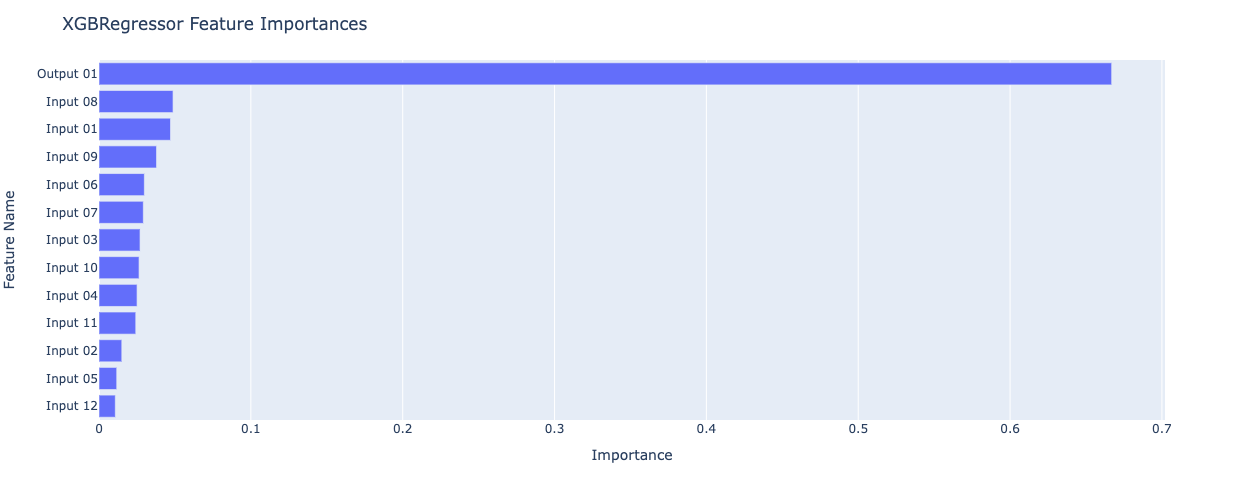

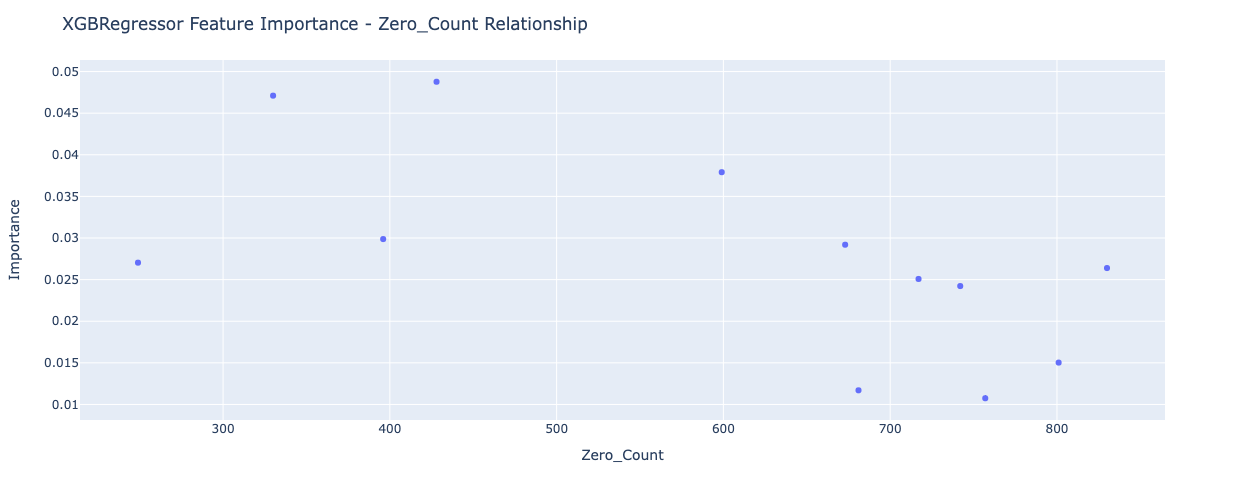

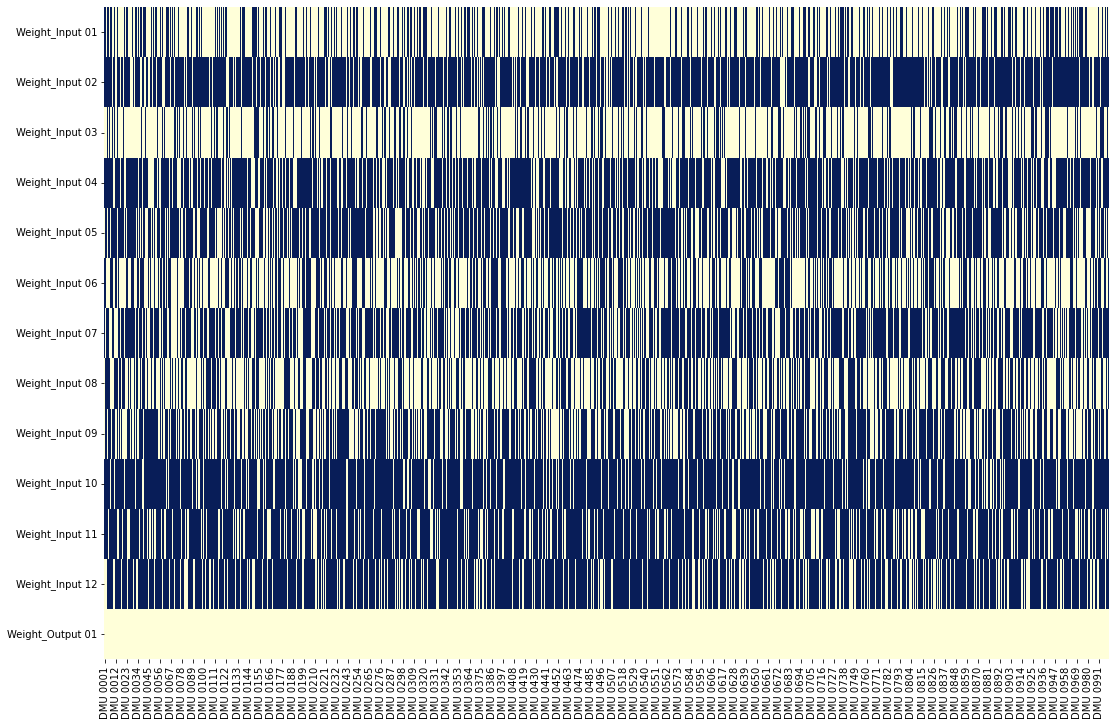

In [21]:
pipe_xgb, r, y, df_merged = ml(i=i)
results.append(r)

In [22]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
5      Input 07    0.029193   Input 07         673          0
6      Input 03    0.027037   Input 03         249          0
7      Input 10    0.026392   Input 10         830          0
8      Input 04    0.025079   Input 04         717          0
9      Input 11    0.024227   Input 11         742          0
10     Input 02    0.015030   Input 02         801          0
11     Input 05    0.011698   Input 05         681          0
12     Input 12    0.010745   Input 12         757          0

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6841  0.7514 -0.0673     -8.9586           False
1        0.8802  0.8656  0.0146      1.6887            True
2        0.9946  1.0000 -0.0054     -0.5372            True
3        0.8819  0.8711  0.0108      1.2396            True
4        0.7562  0.7903 -0.0342     -4.3221           False
..          ...     ...     ...         ...             ...
195      0.7343  0.7837 -0.0494     -6.3041           False
196      0.8674  0.8507  0.0166      1.9550            True
197      0.8356  0.8364 -0.0008     -0.0976            True
198      0.9753  1.0000 -0.0247     -2.4695            True
199      0.8039  0.8264 -0.0224     -2.7149            True

[200 rows x 5 columns]
blue:  107
red:  93
rho: 0.9339
p-Value 0.0


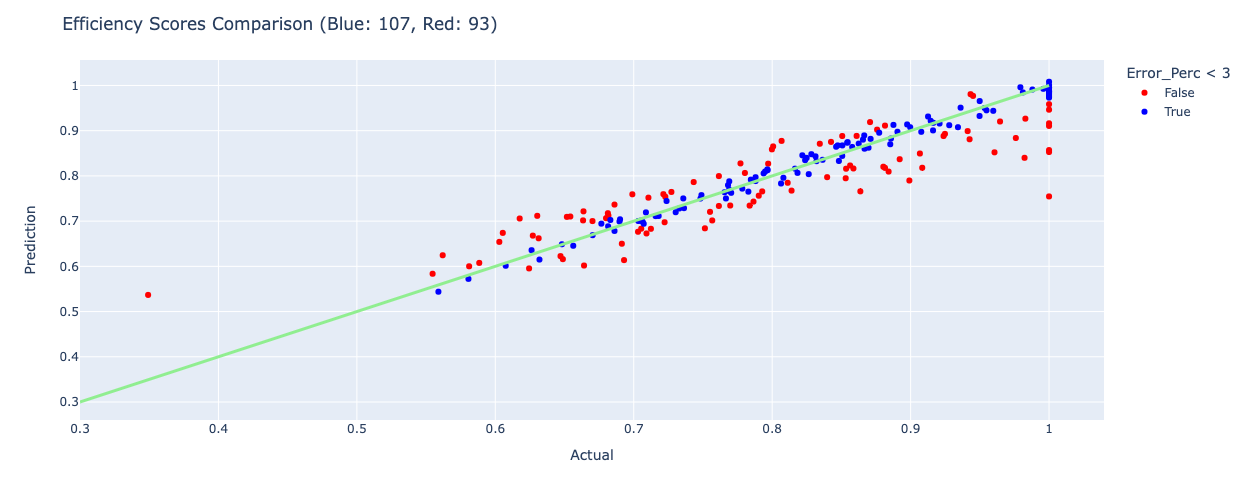

In [23]:
compareML(pipe_xgb, y)

In [24]:
results

[(0,
  'xgbregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 06',
   'Input 07',
   'Input 03',
   'Input 10',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8975120373748599,
   'neg_root_mean_squared_error': -0.04034910223716744,
   'total_zeros': 7203})]

### i = 1

In [25]:
i +=1
i

1

In [26]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       0
Weight_Input 02     714
Weight_Input 03      28
Weight_Input 04     280
Weight_Input 05     803
Weight_Input 06       5
Weight_Input 07      22
Weight_Input 08       0
Weight_Input 09       3
Weight_Input 10     154
Weight_Input 11     441
Weight_Input 12     868
Weight_Output 01      0
dtype: int64
Total Zeros:  3318
neg_mean_squared_error: -0.001006488032353986
neg_root_mean_squared_error: -0.03158914435648219
r2: 0.9215964112044723
grid.best_score:  -0.03262435891479705
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999,

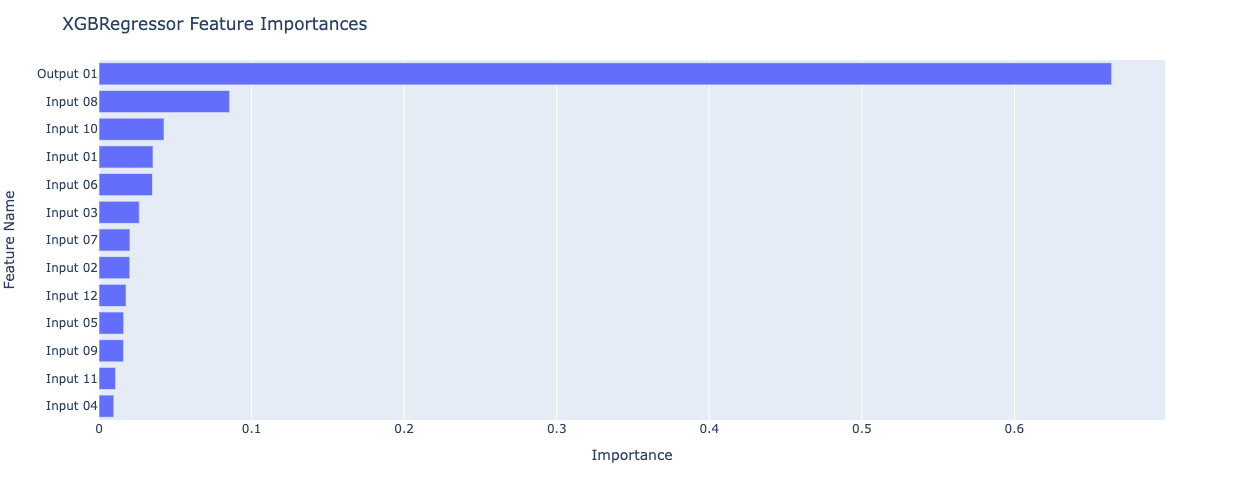

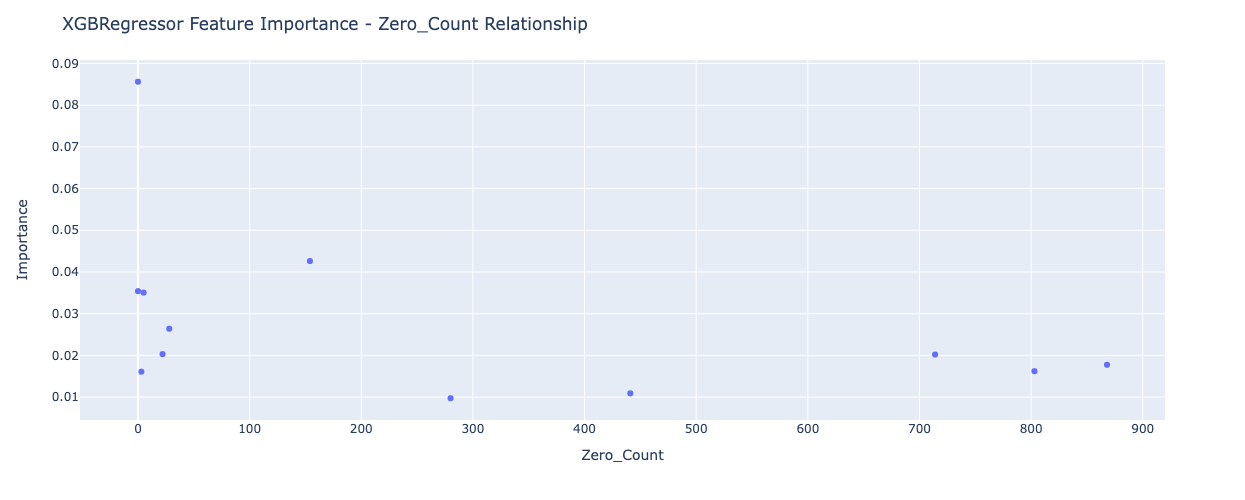

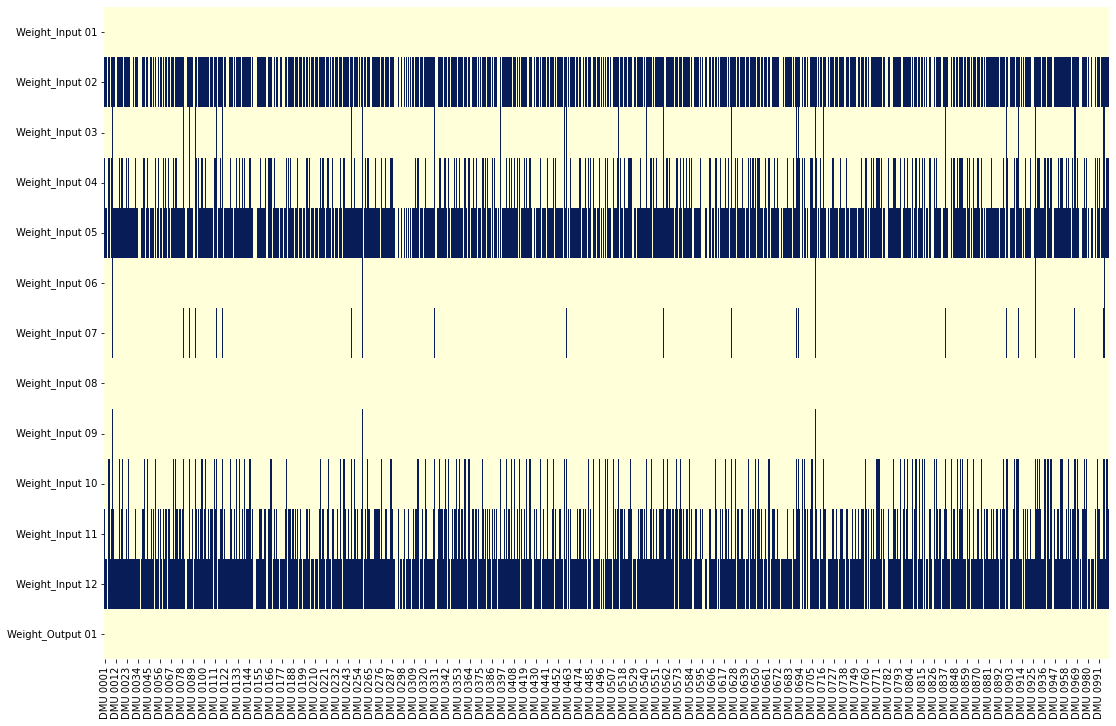

In [27]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_1.xlsx", i=i)
results.append(r)

In [28]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
5      Input 07    0.029193   Input 07         673          0
6      Input 03    0.027037   Input 03         249          0
7      Input 10    0.026392   Input 10         830          0
8      Input 04    0.025079   Input 04         717          0
9      Input 11    0.024227   Input 11         742          0
10     Input 02    0.015030   Input 02         801          0
11     Input 05    0.011698   Input 05         681          0
12     Input 12    0.010745   Input 12         757          0
13    Output 01    0.663753  Output 01           0          1
14     Input 08    0.085620   Input 08           0          1
15     Input 10    0.042618   Input 10         154          1
16     Input 01    0.035400   Input 01           0          1
17     Input 06    0.035047   Input 06           5          1
18     Input 03    0.026399   Input 03          28          1
19     Input 07    0.020300   Input 07          22          1
20     Input 02    0.020203   Input 02         714          1
21     Input 12    0.017746   Input 12         868          1
22     Input 05    0.016207   Input 05         803          1
23     Input 09    0.016091   Input 09           3          1
24     Input 11    0.010896   Input 11         441          1
25     Input 04    0.009719   Input 04         280          1

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6143  0.6311 -0.0168     -2.6694            True
1        0.6765  0.6510  0.0256      3.9257           False
2        0.8170  0.8000  0.0170      2.1280            True
3        0.8838  0.8267  0.0571      6.9045           False
4        0.7264  0.7665 -0.0401     -5.2348           False
..          ...     ...     ...         ...             ...
195      0.7225  0.7171  0.0053      0.7437            True
196      0.8394  0.8075  0.0319      3.9550           False
197      0.7762  0.7921 -0.0158     -1.9988            True
198      0.8125  0.8672 -0.0547     -6.3073           False
199      0.8001  0.8211 -0.0210     -2.5578            True

[200 rows x 5 columns]
blue:  116
red:  84
rho: 0.96
p-Value 0.0


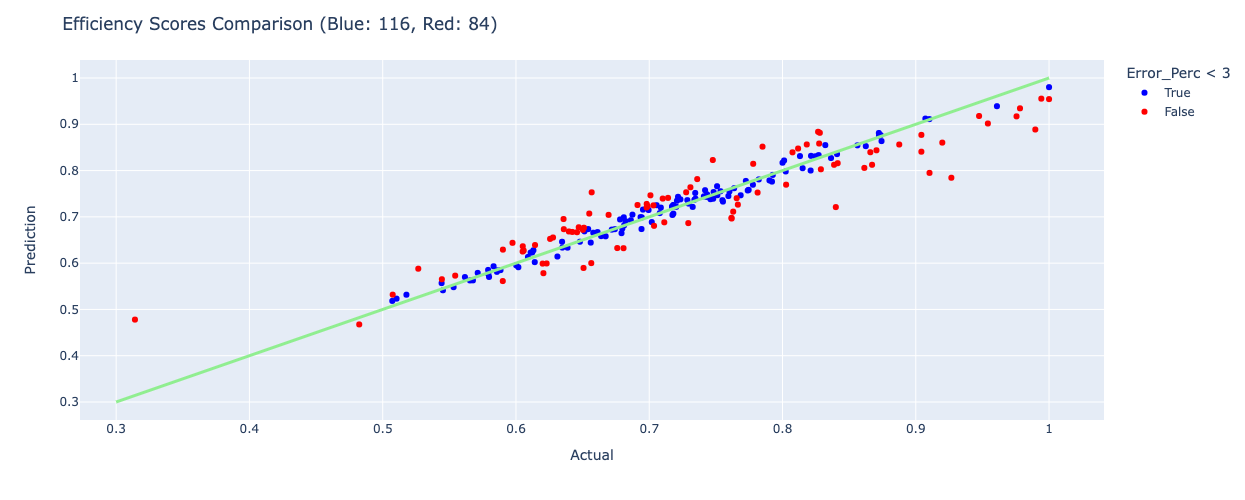

In [29]:
compareML(pipe_xgb, y)

blue :  551
red :  449


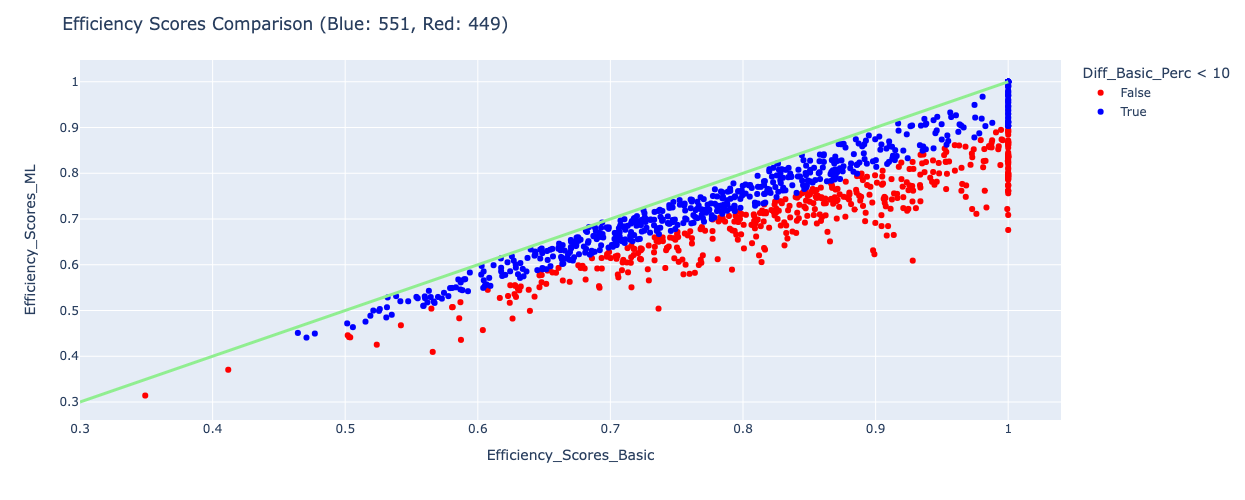

In [30]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_1.xlsx")

### i = 2

In [31]:
i +=1
i

2

In [32]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       7
Weight_Input 02     478
Weight_Input 03     137
Weight_Input 04     690
Weight_Input 05     602
Weight_Input 06      80
Weight_Input 07     231
Weight_Input 08       0
Weight_Input 09     626
Weight_Input 10       1
Weight_Input 11     634
Weight_Input 12     505
Weight_Output 01      0
dtype: int64
Total Zeros:  3991
neg_mean_squared_error: -0.0010124262776147498
neg_root_mean_squared_error: -0.03169111943685031
r2: 0.9298153636762876
grid.best_score:  -0.03060948226575373
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999

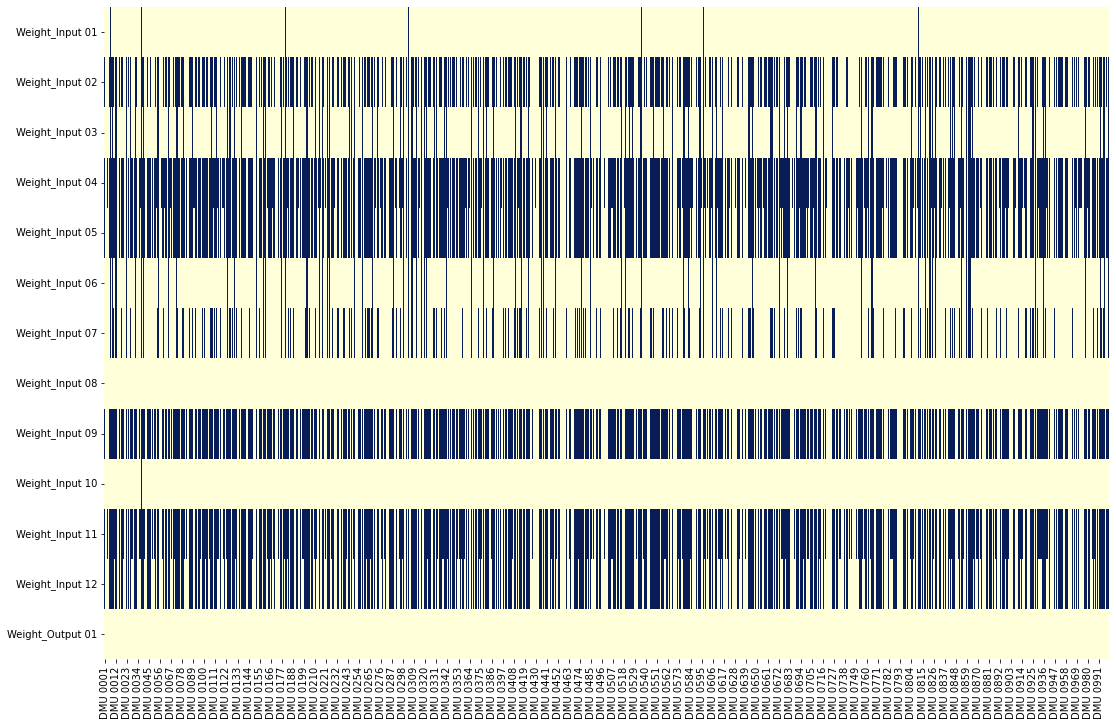

In [33]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_2.xlsx", i=i)
results.append(r)

In [34]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
5      Input 07    0.029193   Input 07         673          0
6      Input 03    0.027037   Input 03         249          0
7      Input 10    0.026392   Input 10         830          0
8      Input 04    0.025079   Input 04         717          0
9      Input 11    0.024227   Input 11         742          0
10     Input 02    0.015030   Input 02         801          0
11     Input 05    0.011698   Input 05         681          0
12     Input 12    0.010745   Input 12         757          0
13    Output 01    0.663753  Output 01           0          1
14     Input 08    0.085620   Input 08           0          1
15     Input 10    0.042618   Input 10         154          1
16     Input 01    0.035400   Input 01           0          1
17     Input 06    0.035047   Input 06           5          1
18     Input 03    0.026399   Input 03          28          1
19     Input 07    0.020300   Input 07          22          1
20     Input 02    0.020203   Input 02         714          1
21     Input 12    0.017746   Input 12         868          1
22     Input 05    0.016207   Input 05         803          1
23     Input 09    0.016091   Input 09           3          1
24     Input 11    0.010896   Input 11         441          1
25     Input 04    0.009719   Input 04         280          1
26    Output 01    0.689465  Output 01           0          2
27     Input 10    0.090576   Input 10           1          2
28     Input 08    0.056242   Input 08           0          2
29     Input 06    0.029116   Input 06          80          2
30     Input 01    0.021572   Input 01           7          2
31     Input 02    0.021414   Input 02         478          2
32     Input 09    0.017465   Input 09         626          2
33     Input 03    0.016487   Input 03         137          2
34     Input 07    0.015511   Input 07         231          2
35     Input 12    0.015046   Input 12         505          2
36     Input 11    0.010654   Input 11         634          2
37     Input 05    0.009103   Input 05         602          2
38     Input 04    0.007349   Input 04         690          2

In [35]:
compareML(pipe_xgb, y)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6429  0.6404  0.0025      0.3874            True
1        0.6718  0.6424  0.0295      4.5853           False
2        0.8052  0.7956  0.0096      1.2044            True
3        0.8423  0.8152  0.0271      3.3253           False
4        0.7099  0.7507 -0.0408     -5.4373           False
..          ...     ...     ...         ...             ...
195      0.6633  0.6761 -0.0128     -1.8968            True
196      0.8395  0.7984  0.0411      5.1502           False
197      0.7704  0.7816 -0.0112     -1.4338            True
198      0.7641  0.8017 -0.0376     -4.6882           False
199      0.7283  0.7471 -0.0187     -2.5087            True

[200 rows x 5 columns]
blue:  116
red:  84
rho: 0.9691
p-Value 0.0


In [36]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_1.xlsx")

blue :  414
red :  586


blue :  958
red :  42


### i = 3

In [37]:
i +=1
i

3

In [38]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      43
Weight_Input 02     149
Weight_Input 03     164
Weight_Input 04     575
Weight_Input 05     392
Weight_Input 06      26
Weight_Input 07     187
Weight_Input 08       1
Weight_Input 09     161
Weight_Input 10       0
Weight_Input 11     253
Weight_Input 12     234
Weight_Output 01      0
dtype: int64
Total Zeros:  2185
neg_mean_squared_error: -0.0007829809014798614
neg_root_mean_squared_error: -0.027869863426637886
r2: 0.9463726419376621
grid.best_score:  -0.027486763029986767
grid.best_params:  {'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7999999999999999, 'xgbregressor__colsample_bylevel': 0.6}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0

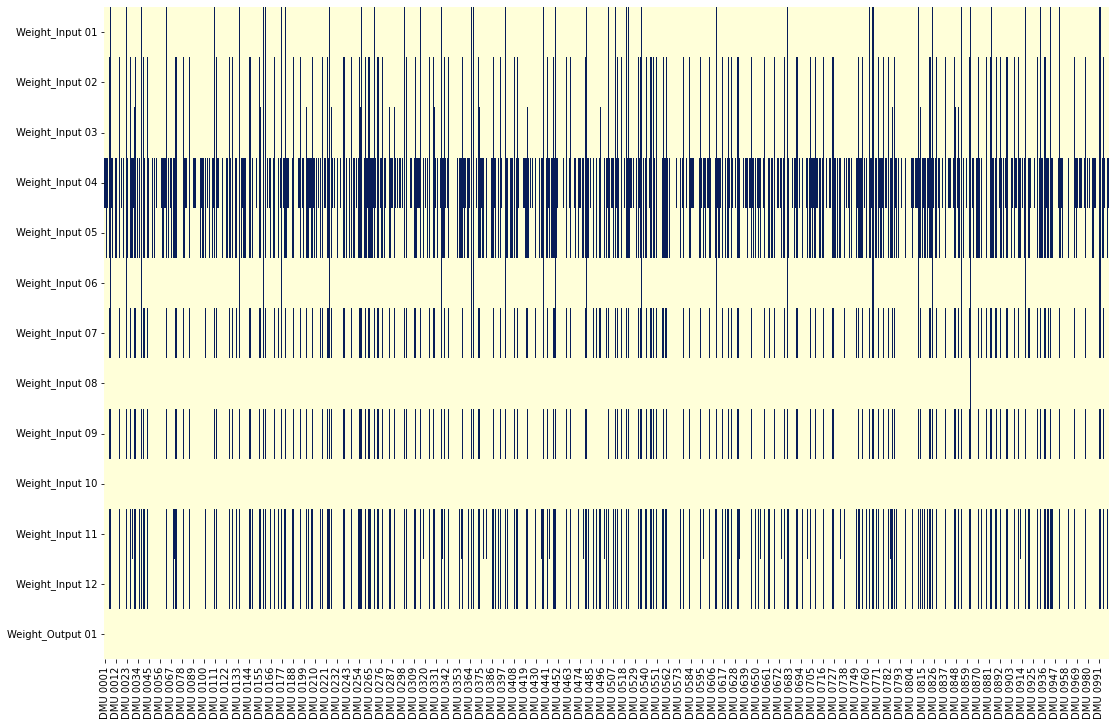

In [39]:
pipe_xgb, r, y,df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_3.xlsx", i=i)
results.append(r)

In [40]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
5      Input 07    0.029193   Input 07         673          0
6      Input 03    0.027037   Input 03         249          0
7      Input 10    0.026392   Input 10         830          0
8      Input 04    0.025079   Input 04         717          0
9      Input 11    0.024227   Input 11         742          0
10     Input 02    0.015030   Input 02         801          0
11     Input 05    0.011698   Input 05         681          0
12     Input 12    0.010745   Input 12         757          0
13    Output 01    0.663753  Output 01           0          1
14     Input 08    0.085620   Input 08           0          1
15     Input 10    0.042618   Input 10         154          1
16     Input 01    0.035400   Input 01           0          1
17     Input 06    0.035047   Input 06           5          1
18     Input 03    0.026399   Input 03          28          1
19     Input 07    0.020300   Input 07          22          1
20     Input 02    0.020203   Input 02         714          1
21     Input 12    0.017746   Input 12         868          1
22     Input 05    0.016207   Input 05         803          1
23     Input 09    0.016091   Input 09           3          1
24     Input 11    0.010896   Input 11         441          1
25     Input 04    0.009719   Input 04         280          1
26    Output 01    0.689465  Output 01           0          2
27     Input 10    0.090576   Input 10           1          2
28     Input 08    0.056242   Input 08           0          2
29     Input 06    0.029116   Input 06          80          2
30     Input 01    0.021572   Input 01           7          2
31     Input 02    0.021414   Input 02         478          2
32     Input 09    0.017465   Input 09         626          2
33     Input 03    0.016487   Input 03         137          2
34     Input 07    0.015511   Input 07         231          2
35     Input 12    0.015046   Input 12         505          2
36     Input 11    0.010654   Input 11         634          2
37     Input 05    0.009103   Input 05         602          2
38     Input 04    0.007349   Input 04         690          2
39    Output 01    0.763853  Output 01           0          3
40     Input 10    0.099878   Input 10           0          3
41     Input 06    0.034570   Input 06          26          3
42     Input 08    0.021205   Input 08           1          3
43     Input 02    0.020149   Input 02         149          3
44     Input 01    0.014894   Input 01          43          3
45     Input 03    0.012378   Input 03         164          3
46     Input 09    0.008488   Input 09         161          3
47     Input 11    0.006635   Input 11         253          3
48     Input 04    0.006527   Input 04         575          3
49     Input 12    0.004202   Input 12         234          3
50     Input 07    0.003817   Input 07         187          3
51     Input 05    0.003404   Input 05         392          3

In [41]:
compareML(pipe_xgb, y)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6270  0.6513 -0.0242     -3.7199           False
1        0.6225  0.6487 -0.0262     -4.0388           False
2        0.7765  0.7856 -0.0090     -1.1514            True
3        0.8069  0.7957  0.0112      1.4093            True
4        0.6516  0.6854 -0.0338     -4.9349           False
..          ...     ...     ...         ...             ...
195      0.6444  0.6535 -0.0092     -1.4028            True
196      0.8295  0.7825  0.0469      5.9975           False
197      0.7580  0.7634 -0.0054     -0.7080            True
198      0.7226  0.7529 -0.0303     -4.0190           False
199      0.7087  0.7368 -0.0280     -3.8060           False

[200 rows x 5 columns]
blue:  117
red:  83
rho: 0.9775
p-Value 0.0


In [42]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_3.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_2.xlsx")

blue :  194
red :  806


blue :  930
red :  70


### i = 4

In [43]:
i +=1
i

4

In [44]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      42
Weight_Input 02      39
Weight_Input 03      85
Weight_Input 04     195
Weight_Input 05     667
Weight_Input 06       3
Weight_Input 07     514
Weight_Input 08      26
Weight_Input 09     135
Weight_Input 10       0
Weight_Input 11     142
Weight_Input 12     487
Weight_Output 01      0
dtype: int64
Total Zeros:  2335
neg_mean_squared_error: -0.0006493872725731376
neg_root_mean_squared_error: -0.02534499831362435
r2: 0.954945089561208
grid.best_score:  -0.025514294262693294
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999

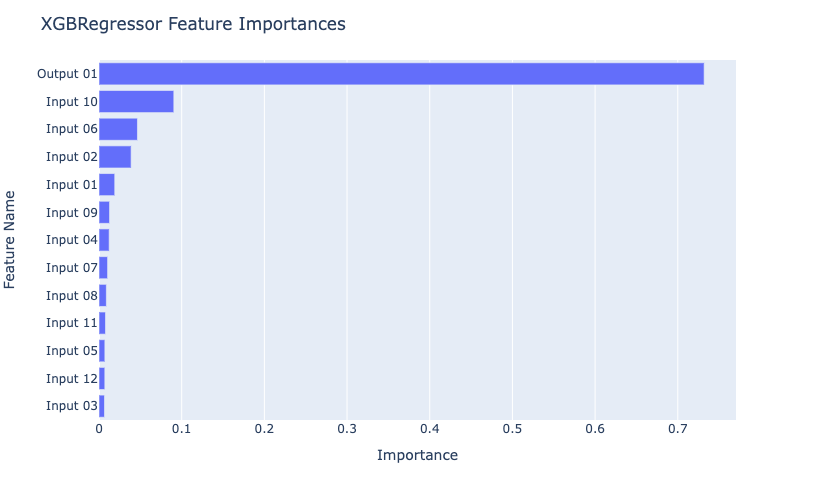

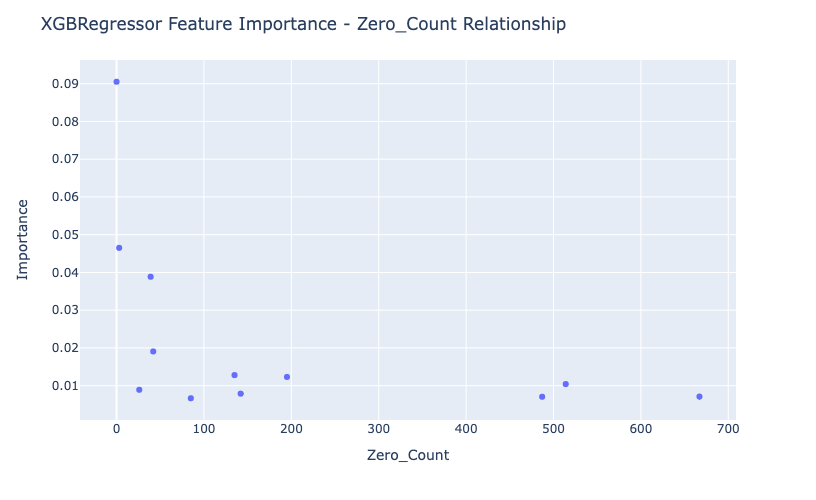

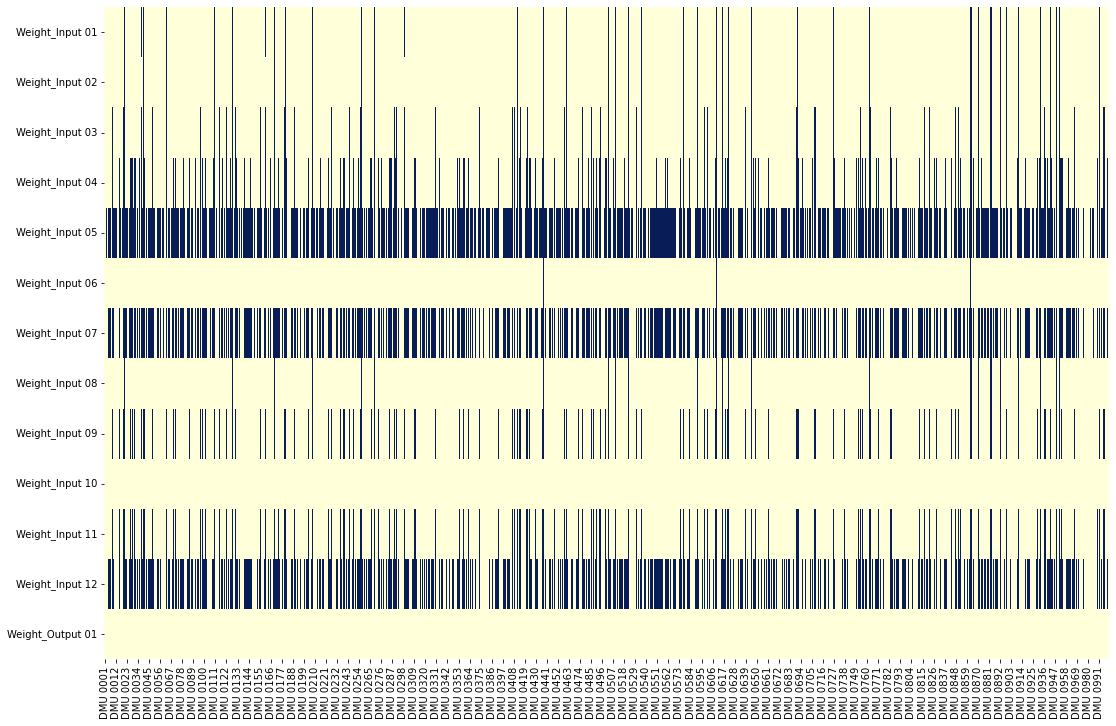

In [45]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_4.xlsx", i=i)
results.append(r)

In [46]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
..          ...         ...        ...         ...        ...
60     Input 08    0.008908   Input 08          26          4
61     Input 11    0.007886   Input 11         142          4
62     Input 05    0.007116   Input 05         667          4
63     Input 12    0.007061   Input 12         487          4
64     Input 03    0.006666   Input 03          85          4

[65 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5918  0.6744 -0.0825    -12.2347           False
1        0.6215  0.6421 -0.0206     -3.2088           False
2        0.7683  0.7774 -0.0092     -1.1800            True
3        0.7602  0.7931 -0.0329     -4.1533           False
4        0.6347  0.6337  0.0009      0.1461            True
..          ...     ...     ...         ...             ...
195      0.6101  0.6459 -0.0358     -5.5411           False
196      0.7976  0.7722  0.0253      3.2826           False
197      0.7337  0.7483 -0.0147     -1.9585            True
198      0.7149  0.7413 -0.0264     -3.5599           False
199      0.6736  0.6843 -0.0107     -1.5706            True

[200 rows x 5 columns]
blue:  117
red:  83
rho: 0.9755
p-Value 0.0


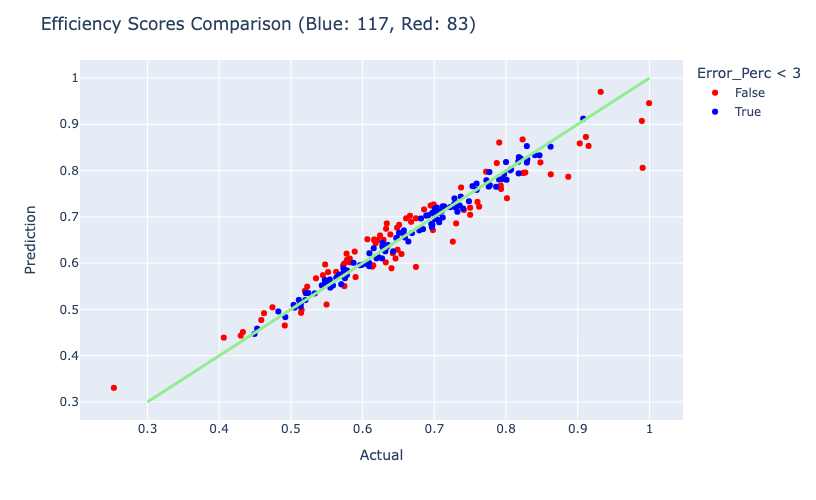

In [47]:
compareML(pipe_xgb, y)

blue :  140
red :  860


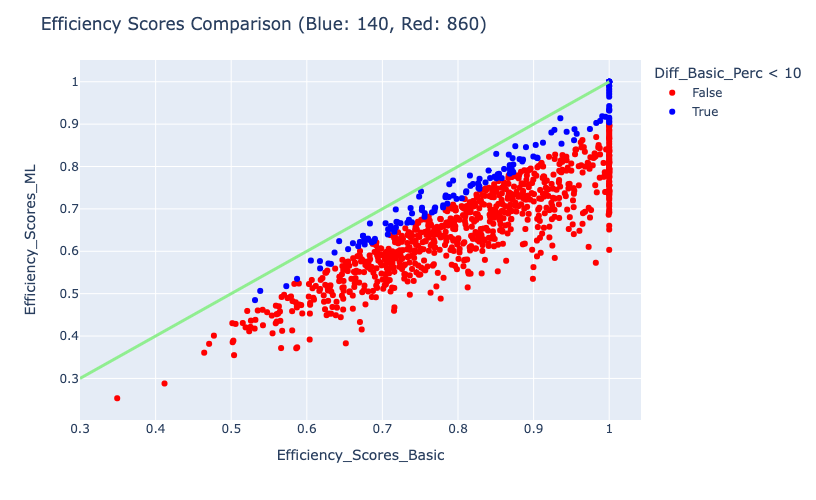

blue :  982
red :  18


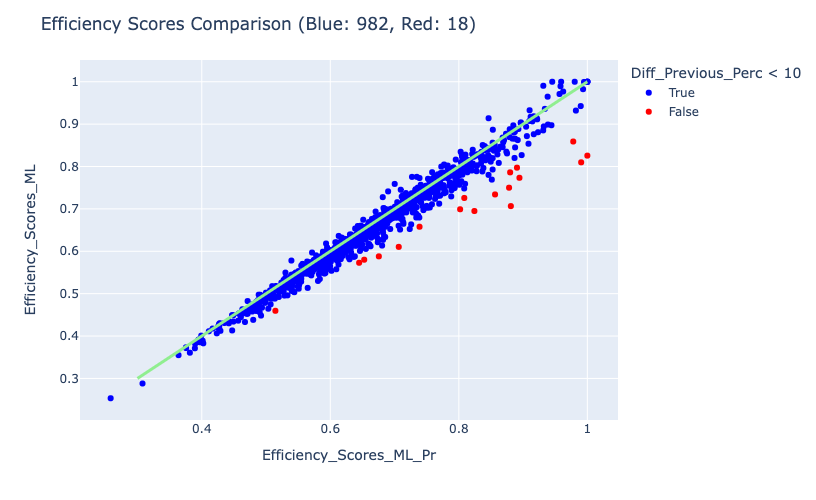

In [48]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_4.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_3.xlsx")

### i = 5

In [49]:
i +=1
i

5

In [50]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      34
Weight_Input 02      30
Weight_Input 03     765
Weight_Input 04     151
Weight_Input 05     439
Weight_Input 06       3
Weight_Input 07     167
Weight_Input 08     184
Weight_Input 09     107
Weight_Input 10       0
Weight_Input 11     247
Weight_Input 12     722
Weight_Output 01      0
dtype: int64
Total Zeros:  2849
neg_mean_squared_error: -0.0006532785330465202
neg_root_mean_squared_error: -0.0254134696242981
r2: 0.9562723932762651
grid.best_score:  -0.025665140776581448
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999

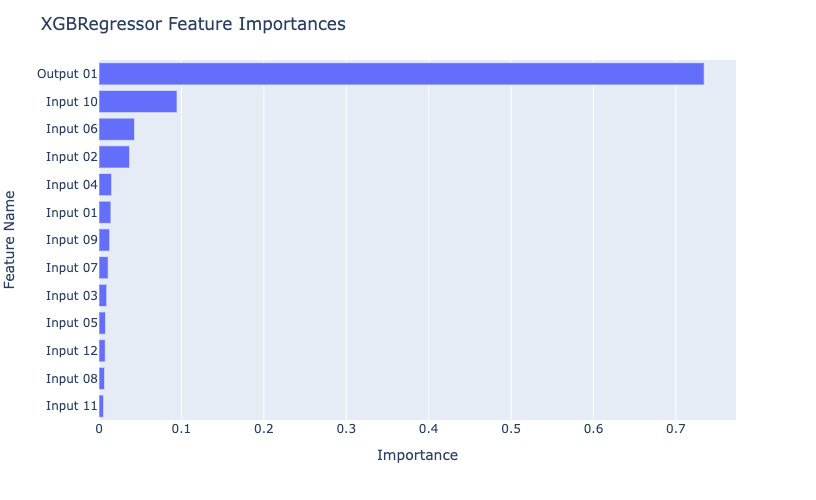

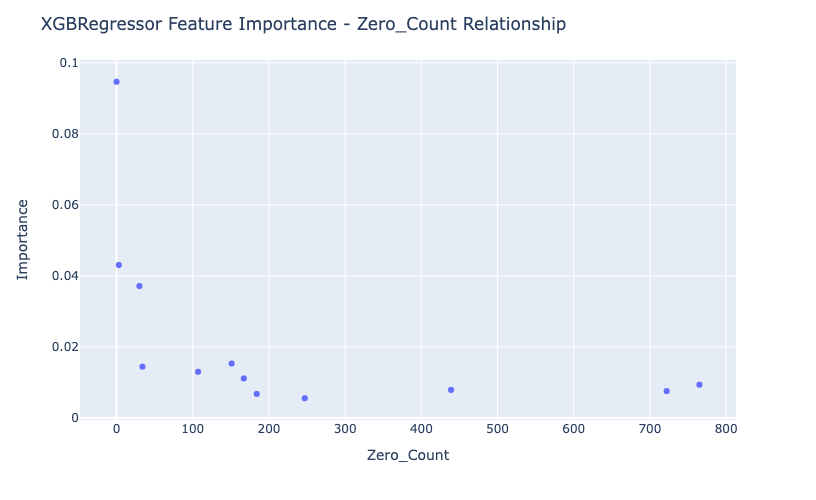

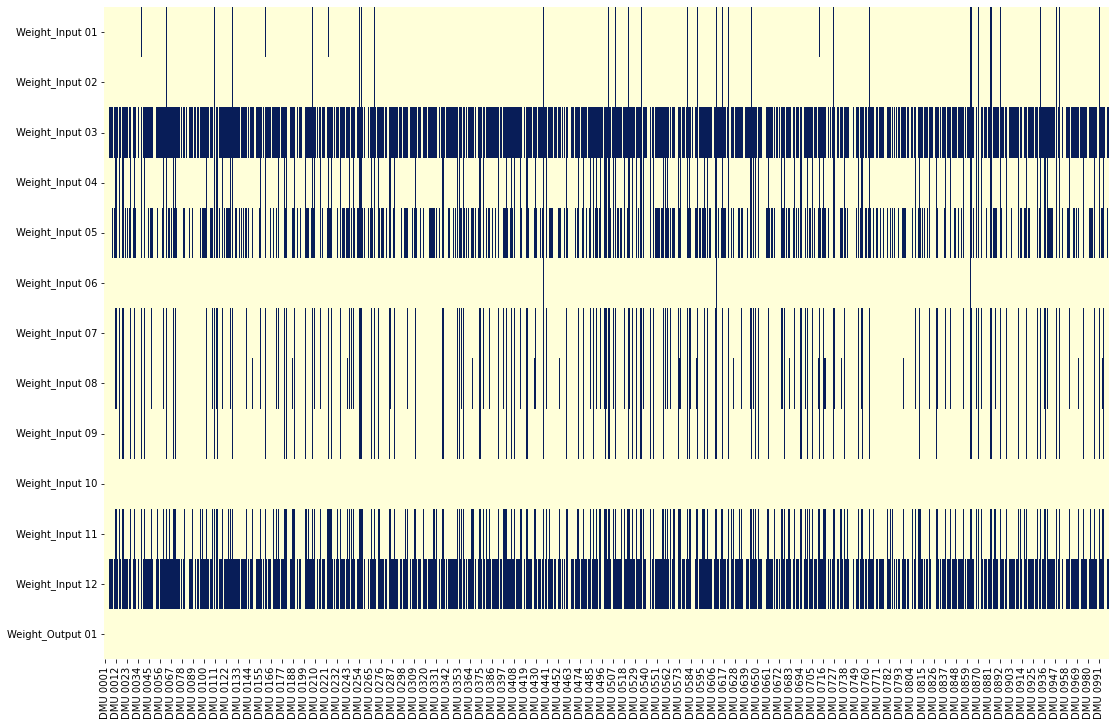

In [51]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_5.xlsx", i=i)
results.append(r)

In [52]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
..          ...         ...        ...         ...        ...
73     Input 03    0.009353   Input 03         765          5
74     Input 05    0.007878   Input 05         439          5
75     Input 12    0.007550   Input 12         722          5
76     Input 08    0.006745   Input 08         184          5
77     Input 11    0.005533   Input 11         247          5

[78 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6142  0.6744 -0.0602     -8.9244           False
1        0.6068  0.6223 -0.0155     -2.4965            True
2        0.7723  0.7786 -0.0062     -0.7986            True
3        0.8028  0.7697  0.0332      4.3074           False
4        0.6127  0.6293 -0.0166     -2.6337            True
..          ...     ...     ...         ...             ...
195      0.6092  0.6473 -0.0381     -5.8811           False
196      0.8483  0.7652  0.0831     10.8638           False
197      0.7520  0.7554 -0.0034     -0.4474            True
198      0.7017  0.7367 -0.0350     -4.7506           False
199      0.6758  0.6618  0.0141      2.1296            True

[200 rows x 5 columns]
blue:  118
red:  82
rho: 0.979
p-Value 0.0


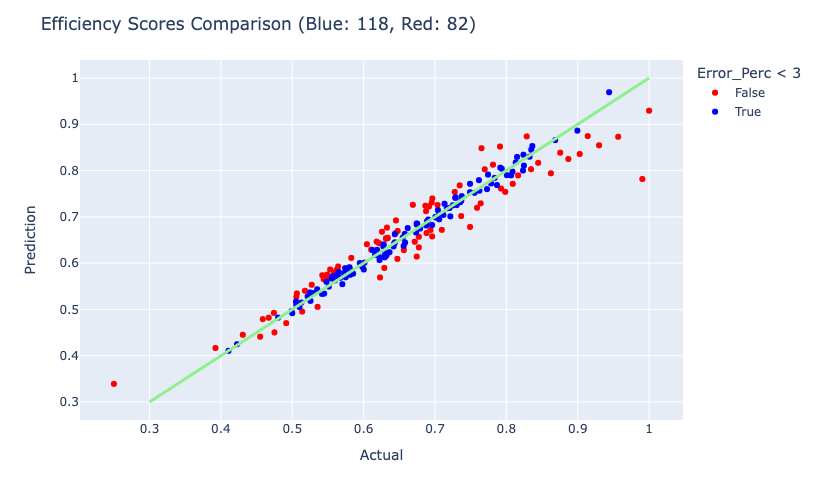

In [53]:
compareML(pipe_xgb, y)

blue :  138
red :  862


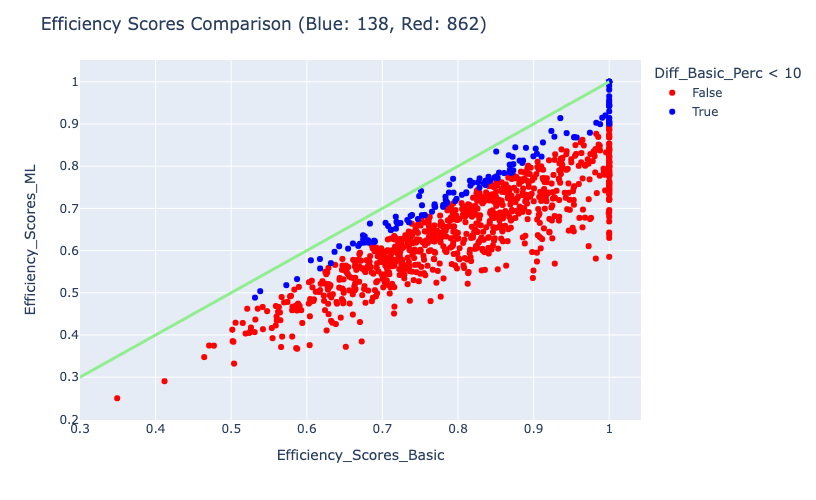

blue :  1000
red :  0


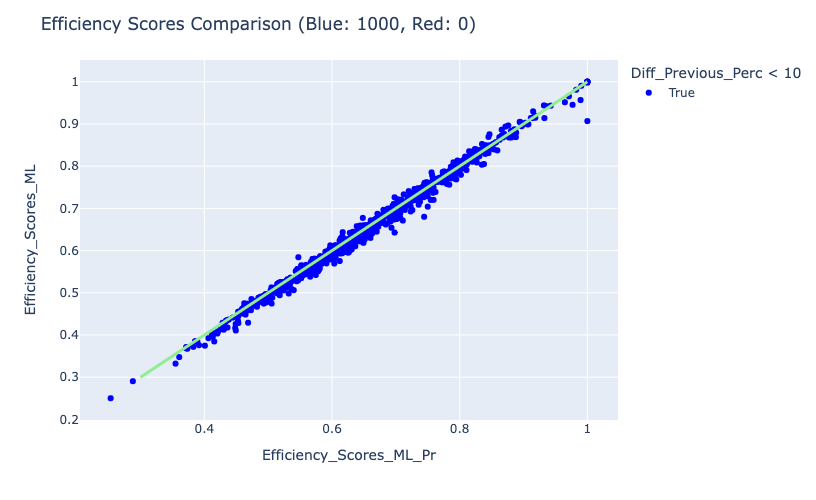

In [54]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_5.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_4.xlsx")

### i = 6

In [55]:
i +=1
i

6

In [56]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      55
Weight_Input 02      23
Weight_Input 03     172
Weight_Input 04      29
Weight_Input 05     396
Weight_Input 06       3
Weight_Input 07     105
Weight_Input 08     676
Weight_Input 09      86
Weight_Input 10       0
Weight_Input 11     709
Weight_Input 12     646
Weight_Output 01      0
dtype: int64
Total Zeros:  2900
neg_mean_squared_error: -0.0006495349125353168
neg_root_mean_squared_error: -0.025364102410849677
r2: 0.9562344864423826
grid.best_score:  -0.02486647278363733
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.799999999999999

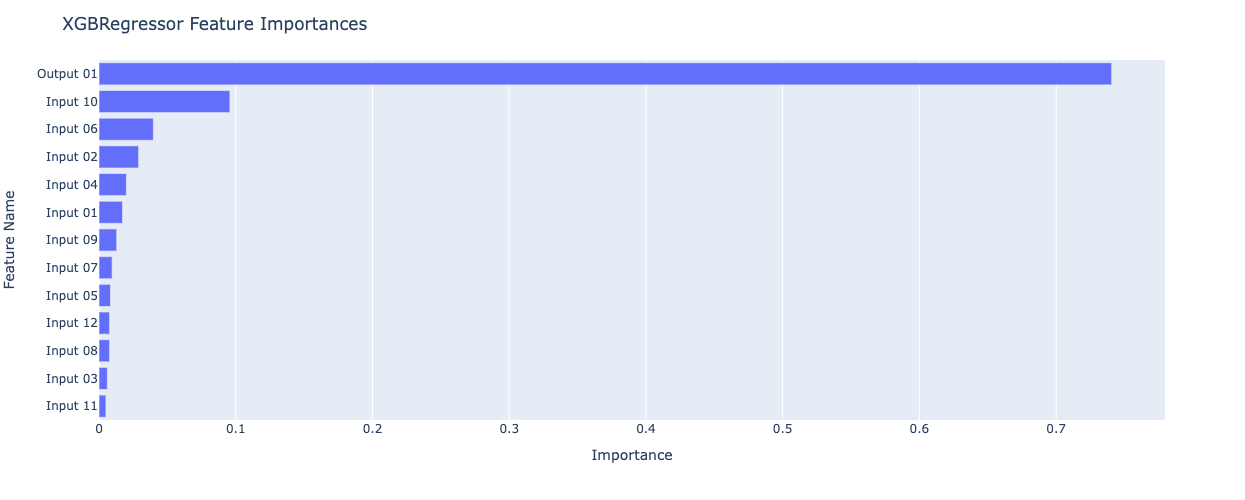

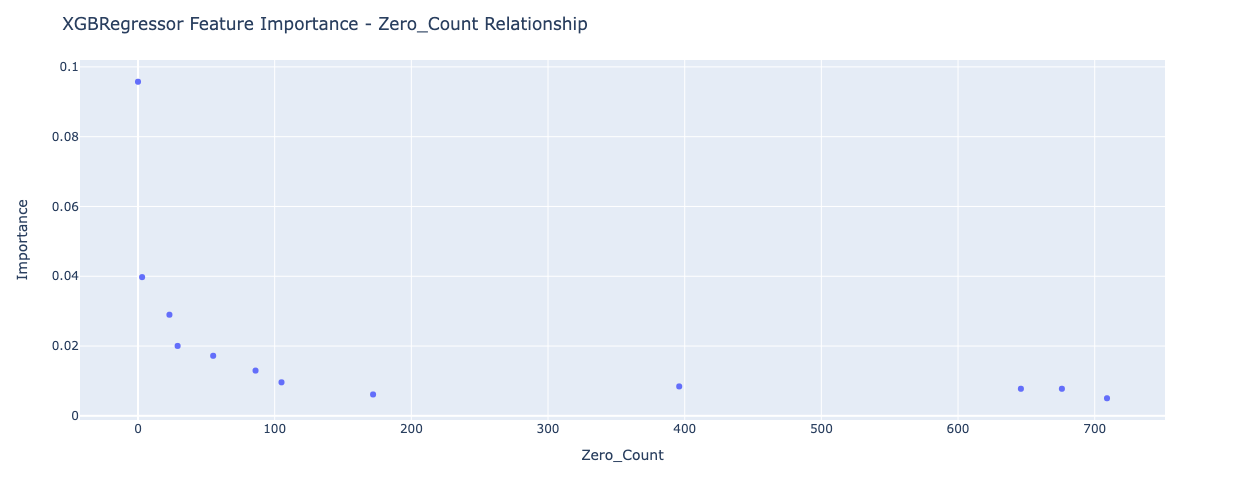

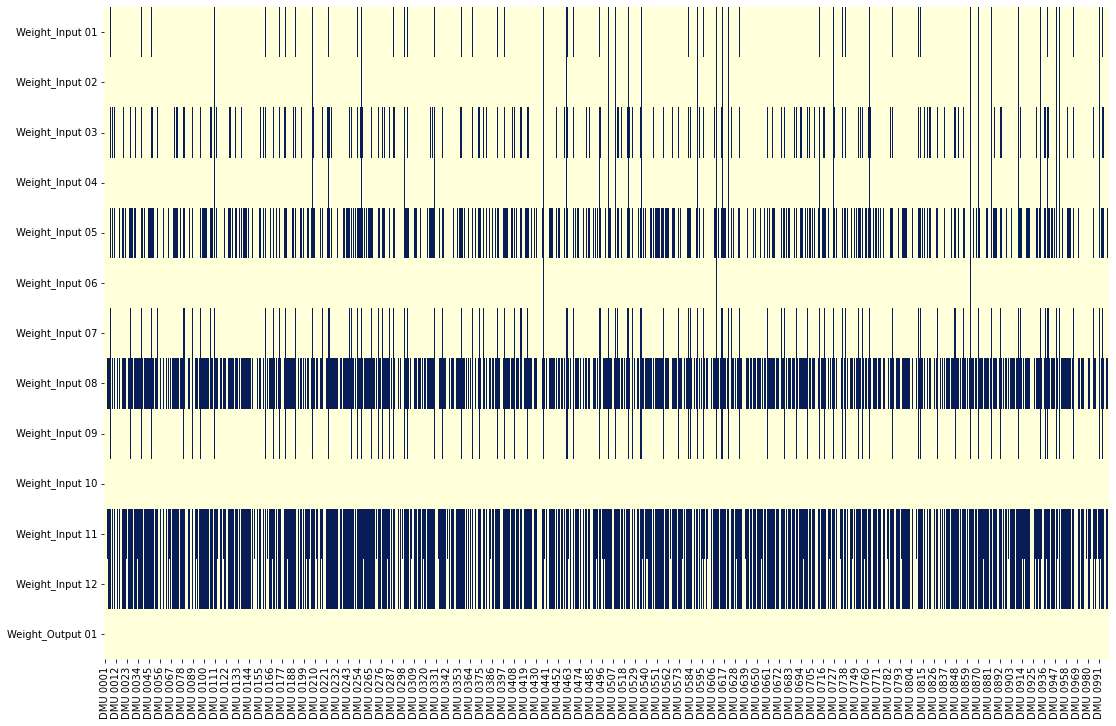

In [57]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_6.xlsx", i=i)
results.append(r)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6006  0.6744 -0.0738    -10.9365           False
1        0.6481  0.6246  0.0235      3.7610           False
2        0.7794  0.7774  0.0020      0.2512            True
3        0.7812  0.7626  0.0186      2.4409            True
4        0.6025  0.6266 -0.0240     -3.8342           False
..          ...     ...     ...         ...             ...
195      0.6009  0.5937  0.0072      1.2144            True
196      0.7868  0.7655  0.0212      2.7744            True
197      0.7490  0.7461  0.0029      0.3863            True
198      0.7058  0.7291 -0.0233     -3.1910           False
199      0.6666  0.6580  0.0085      1.2966            True

[200 rows x 5 columns]
blue:  127
red:  73
rho: 0.9825
p-Value 0.0


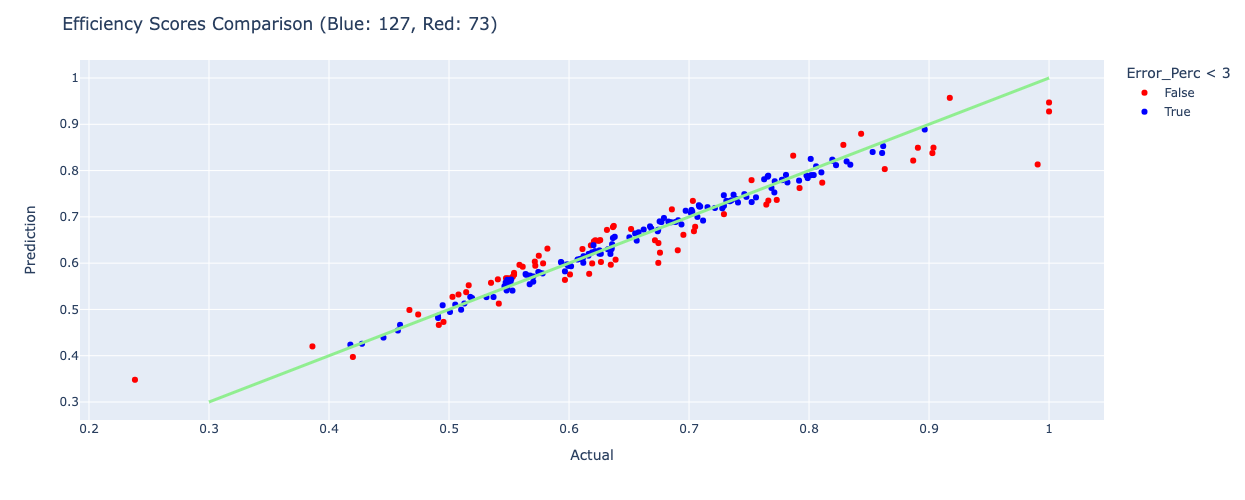

In [58]:
compareML(pipe_xgb, y)

In [59]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.666940  Output 01           0          0
1      Input 08    0.048775   Input 08         428          0
2      Input 01    0.047104   Input 01         330          0
3      Input 09    0.037908   Input 09         599          0
4      Input 06    0.029872   Input 06         396          0
..          ...         ...        ...         ...        ...
86     Input 05    0.008428   Input 05         396          6
87     Input 12    0.007756   Input 12         646          6
88     Input 08    0.007753   Input 08         676          6
89     Input 03    0.006123   Input 03         172          6
90     Input 11    0.005036   Input 11         709          6

[91 rows x 5 columns]

blue :  119
red :  881


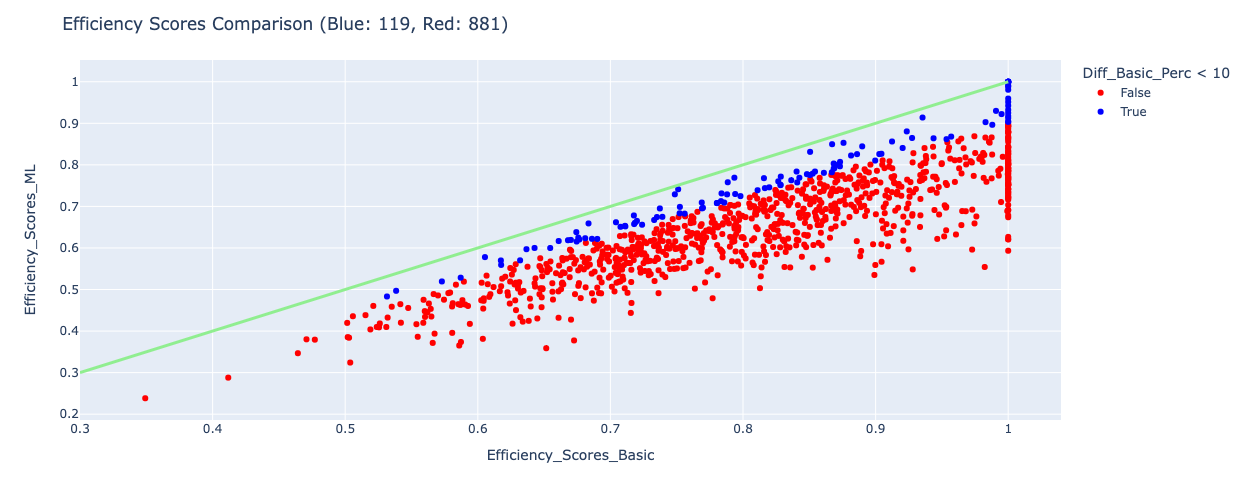

blue :  1000
red :  0


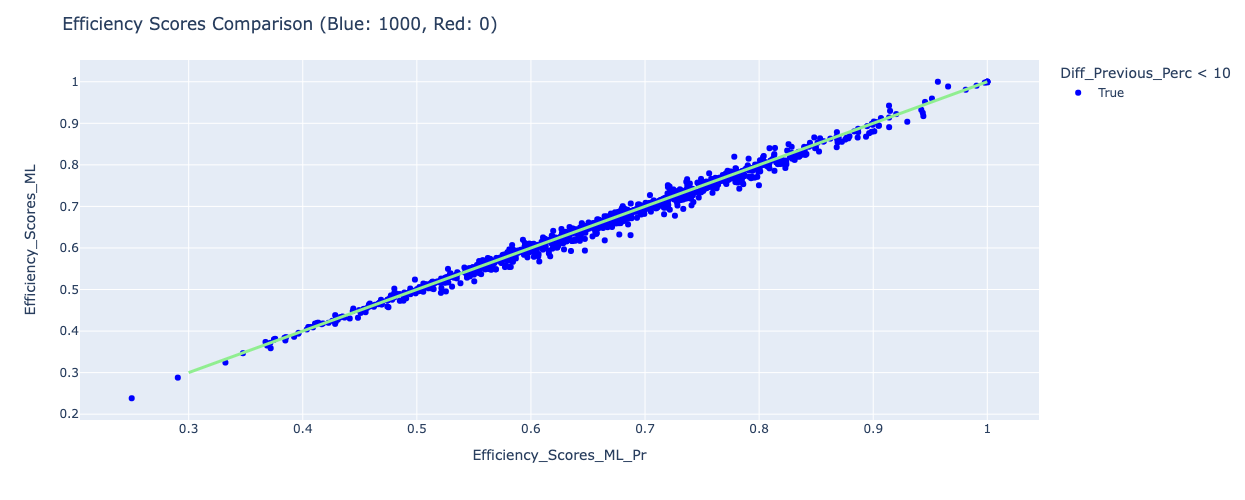

In [60]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_6.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_5.xlsx")

### i = 7

In [61]:
i +=1
i

7

In [62]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      73
Weight_Input 02      30
Weight_Input 03     553
Weight_Input 04      36
Weight_Input 05     314
Weight_Input 06       3
Weight_Input 07     189
Weight_Input 08     457
Weight_Input 09     157
Weight_Input 10       0
Weight_Input 11     587
Weight_Input 12     430
Weight_Output 01      0
dtype: int64
Total Zeros:  2829
neg_mean_squared_error: -0.0006647420871188322
neg_root_mean_squared_error: -0.025564848816137874
r2: 0.9558398544664828
grid.best_score:  -0.025200544909300265
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.79999999999999

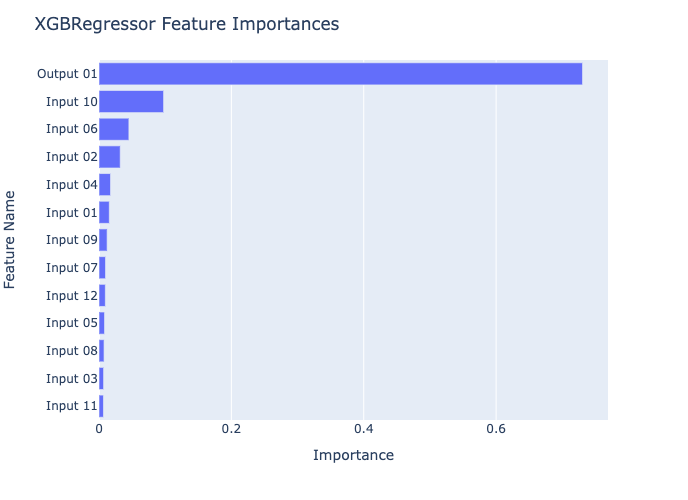

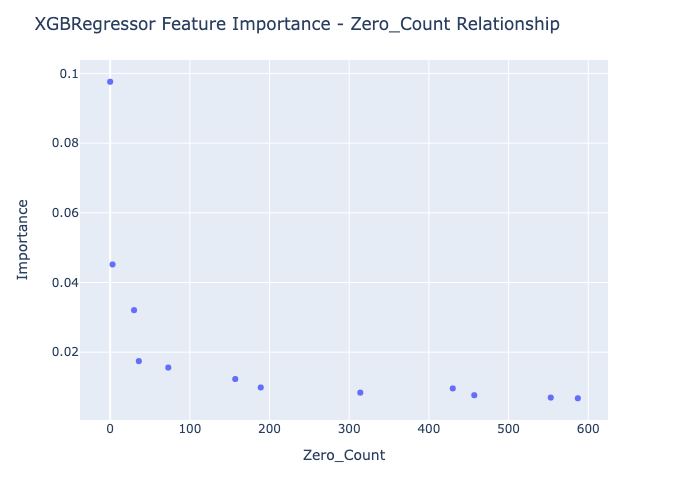

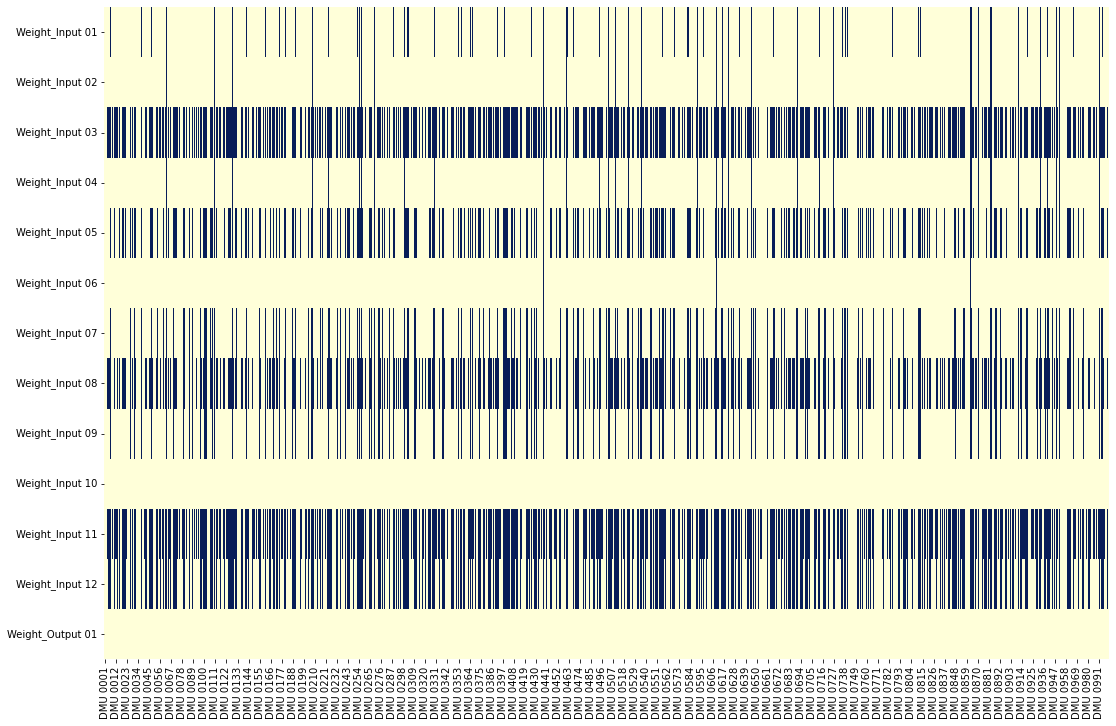

In [63]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_7.xlsx", i=i)
results.append(r)

In [64]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.666940  Output 01           0          0
1       Input 08    0.048775   Input 08         428          0
2       Input 01    0.047104   Input 01         330          0
3       Input 09    0.037908   Input 09         599          0
4       Input 06    0.029872   Input 06         396          0
..           ...         ...        ...         ...        ...
99      Input 12    0.009597   Input 12         430          7
100     Input 05    0.008388   Input 05         314          7
101     Input 08    0.007641   Input 08         457          7
102     Input 03    0.006961   Input 03         553          7
103     Input 11    0.006770   Input 11         587          7

[104 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5964  0.6744 -0.0779    -11.5553           False
1        0.6268  0.6246  0.0023      0.3647            True
2        0.7786  0.7774  0.0011      0.1473            True
3        0.7759  0.7626  0.0133      1.7483            True
4        0.6104  0.6235 -0.0131     -2.1043            True
..          ...     ...     ...         ...             ...
195      0.5967  0.5937  0.0030      0.5010            True
196      0.8008  0.7655  0.0352      4.6013           False
197      0.7446  0.7463 -0.0017     -0.2295            True
198      0.6978  0.7276 -0.0297     -4.0839           False
199      0.6591  0.6580  0.0011      0.1679            True

[200 rows x 5 columns]
blue:  135
red:  65
rho: 0.9818
p-Value 0.0


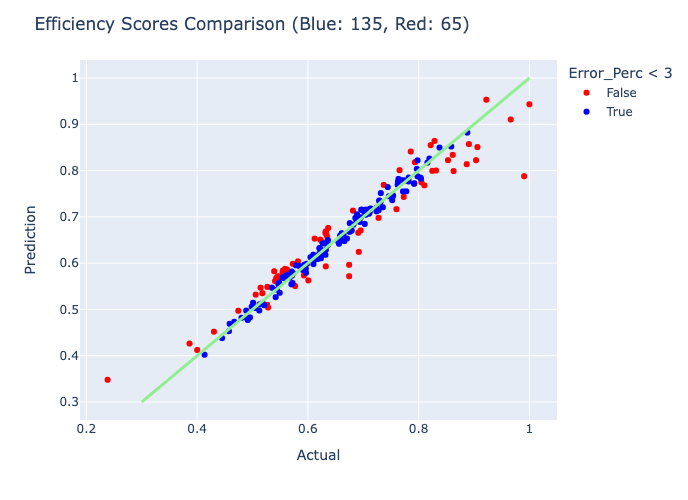

In [65]:
compareML(pipe_xgb, y)

blue :  112
red :  888


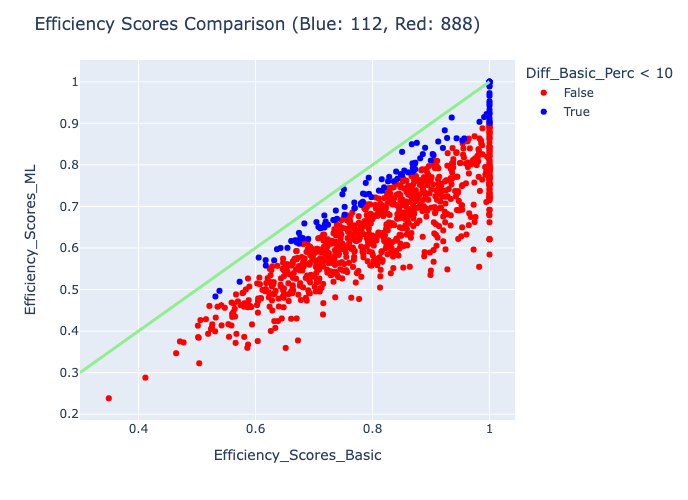

blue :  1000
red :  0


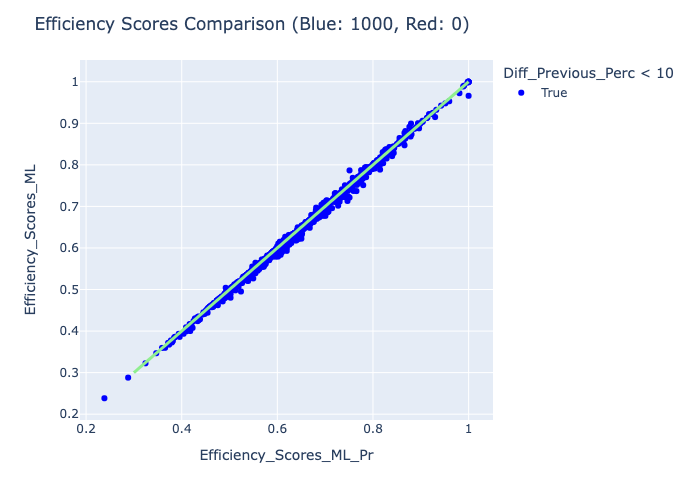

In [66]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_7.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_6.xlsx")

### i = 8

In [67]:
i +=1
i

8

In [68]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      76
Weight_Input 02      32
Weight_Input 03     474
Weight_Input 04      38
Weight_Input 05     352
Weight_Input 06       3
Weight_Input 07     191
Weight_Input 08     380
Weight_Input 09     160
Weight_Input 10       0
Weight_Input 11     511
Weight_Input 12     321
Weight_Output 01      0
dtype: int64
Total Zeros:  2538
neg_mean_squared_error: -0.0006432204448913761
neg_root_mean_squared_error: -0.025124032672866246
r2: 0.9570194465260922
grid.best_score:  -0.024570950179591815
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.79999999999999

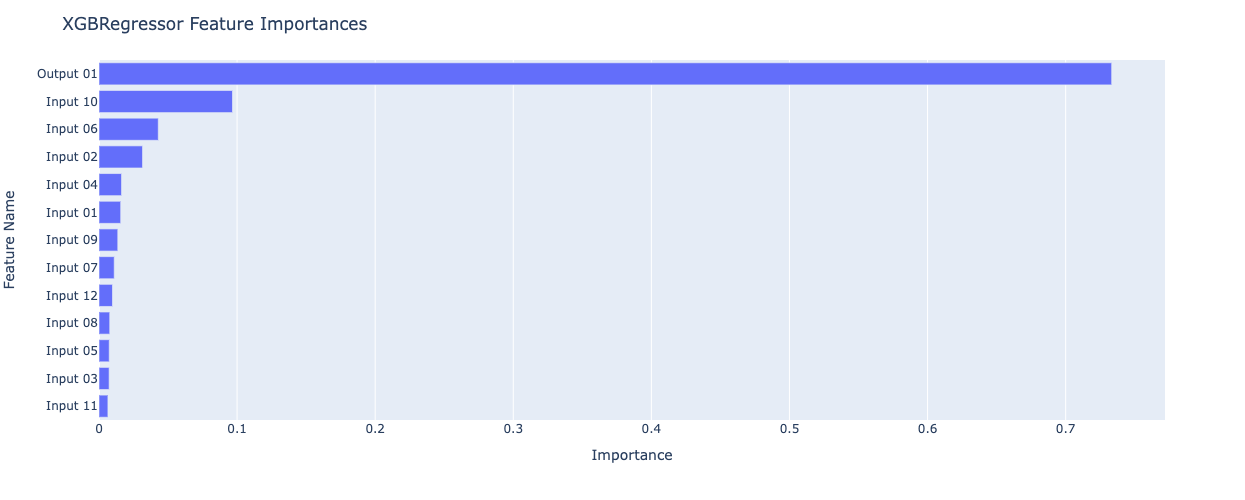

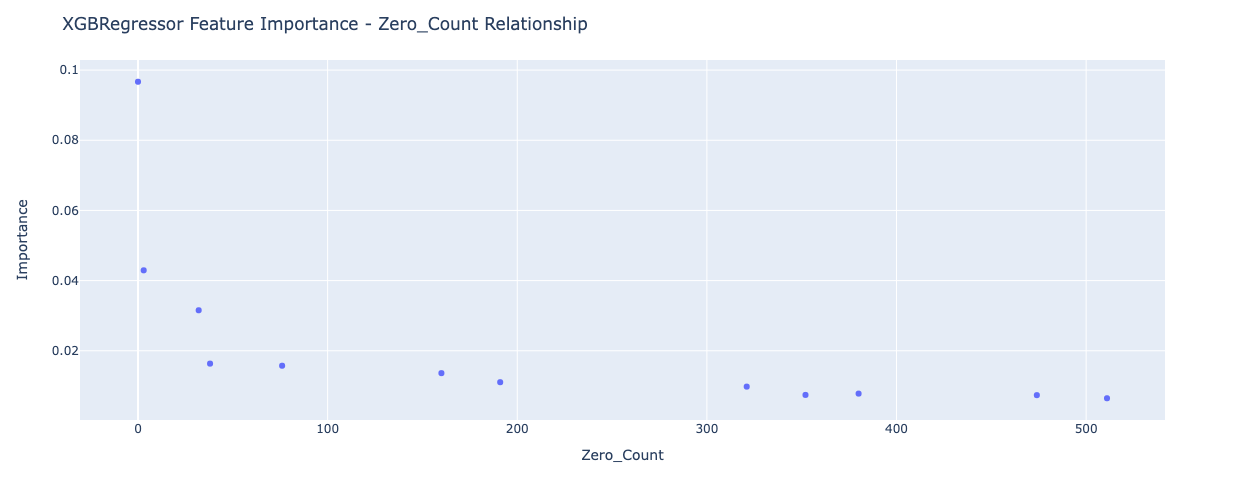

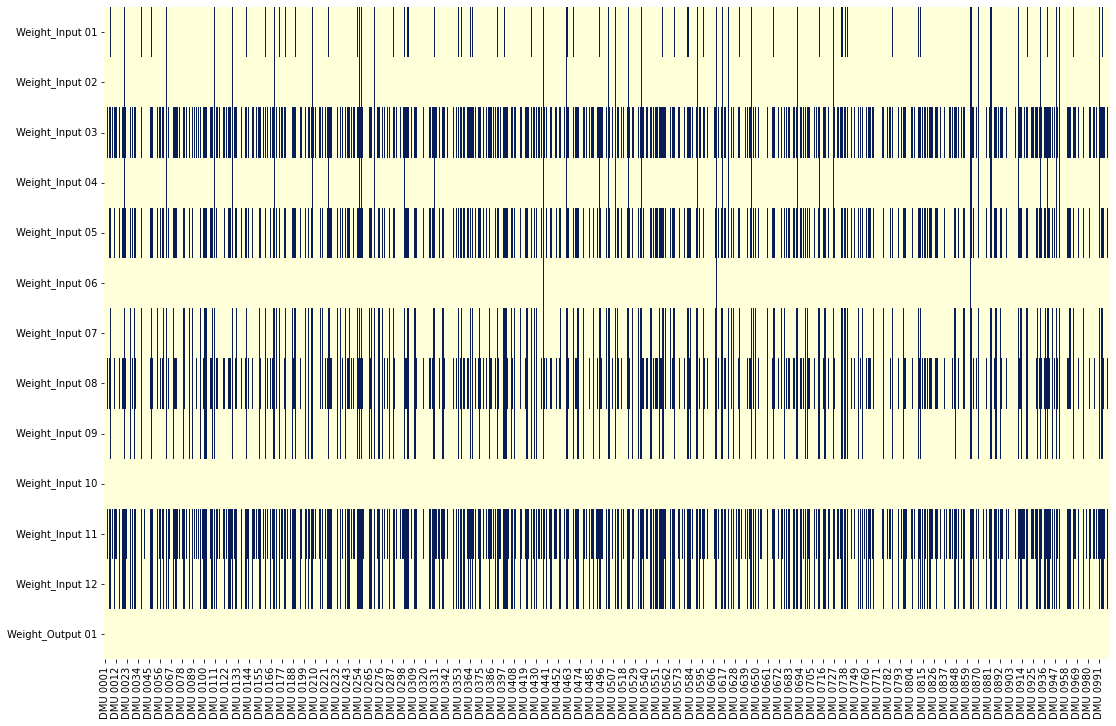

In [69]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_8.xlsx", i=i)
results.append(r)

In [70]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.666940  Output 01           0          0
1       Input 08    0.048775   Input 08         428          0
2       Input 01    0.047104   Input 01         330          0
3       Input 09    0.037908   Input 09         599          0
4       Input 06    0.029872   Input 06         396          0
..           ...         ...        ...         ...        ...
112     Input 12    0.009778   Input 12         321          8
113     Input 08    0.007789   Input 08         380          8
114     Input 05    0.007413   Input 05         352          8
115     Input 03    0.007347   Input 03         474          8
116     Input 11    0.006464   Input 11         511          8

[117 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5936  0.6744 -0.0807    -11.9690           False
1        0.6248  0.6246  0.0002      0.0341            True
2        0.7879  0.7774  0.0105      1.3443            True
3        0.7845  0.7626  0.0219      2.8766            True
4        0.6239  0.6209  0.0030      0.4797            True
..          ...     ...     ...         ...             ...
195      0.5996  0.5937  0.0058      0.9813            True
196      0.8094  0.7655  0.0438      5.7240           False
197      0.7475  0.7461  0.0014      0.1821            True
198      0.7099  0.7276 -0.0177     -2.4339            True
199      0.6633  0.6580  0.0053      0.8048            True

[200 rows x 5 columns]
blue:  130
red:  70
rho: 0.9818
p-Value 0.0


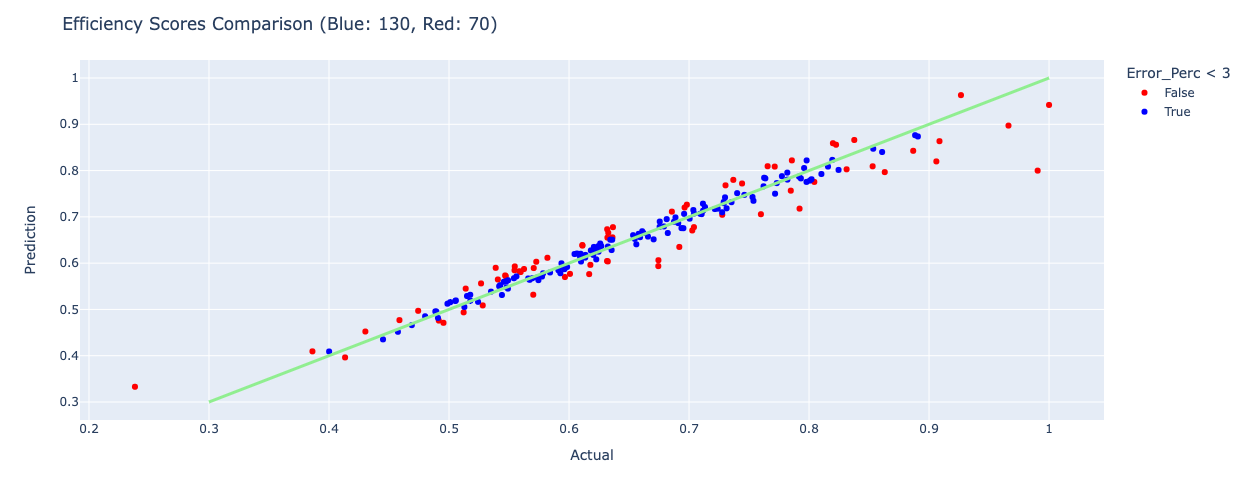

In [71]:
compareML(pipe_xgb, y)

blue :  108
red :  892


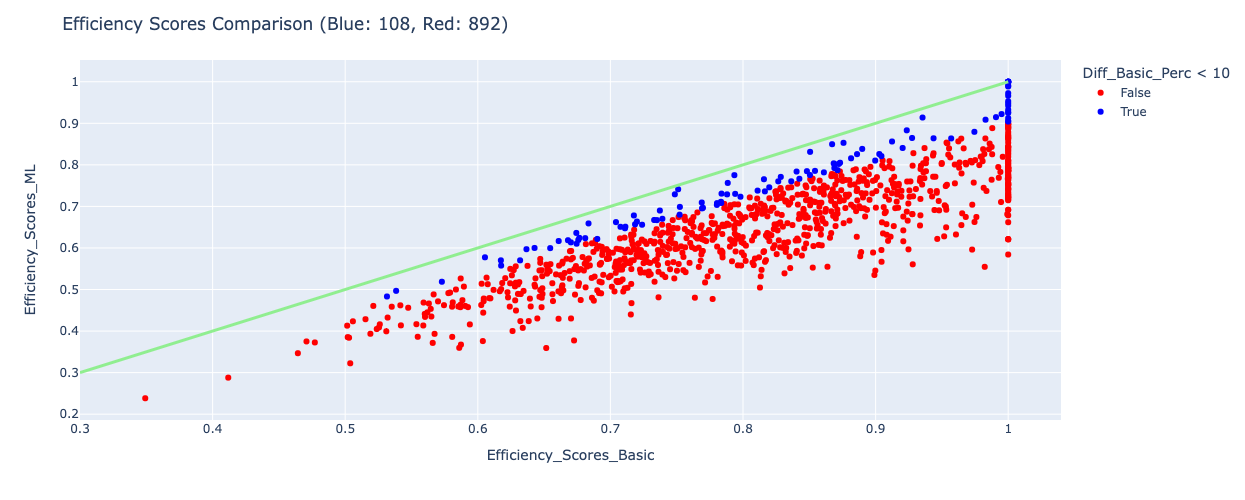

blue :  1000
red :  0


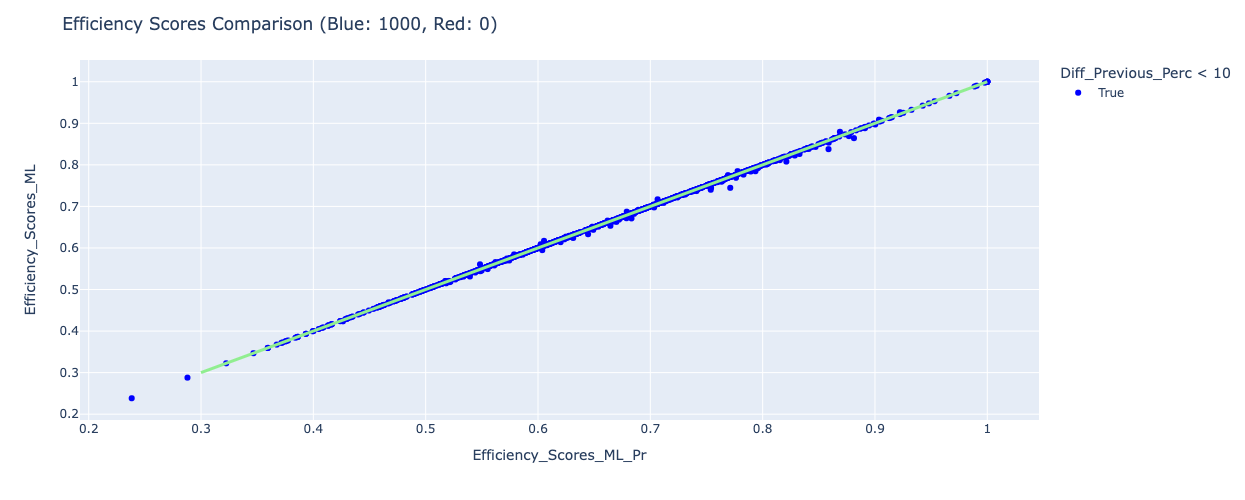

In [72]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_8.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_7.xlsx")

### i = 9

In [73]:
i +=1
i

9

In [74]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      74
Weight_Input 02      32
Weight_Input 03     469
Weight_Input 04      38
Weight_Input 05     391
Weight_Input 06       3
Weight_Input 07     179
Weight_Input 08     296
Weight_Input 09     157
Weight_Input 10       0
Weight_Input 11     504
Weight_Input 12     280
Weight_Output 01      0
dtype: int64
Total Zeros:  2423
neg_mean_squared_error: -0.0006510686289208569
neg_root_mean_squared_error: -0.02541645574278642
r2: 0.9564964729317372
grid.best_score:  -0.02510546780288595
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999

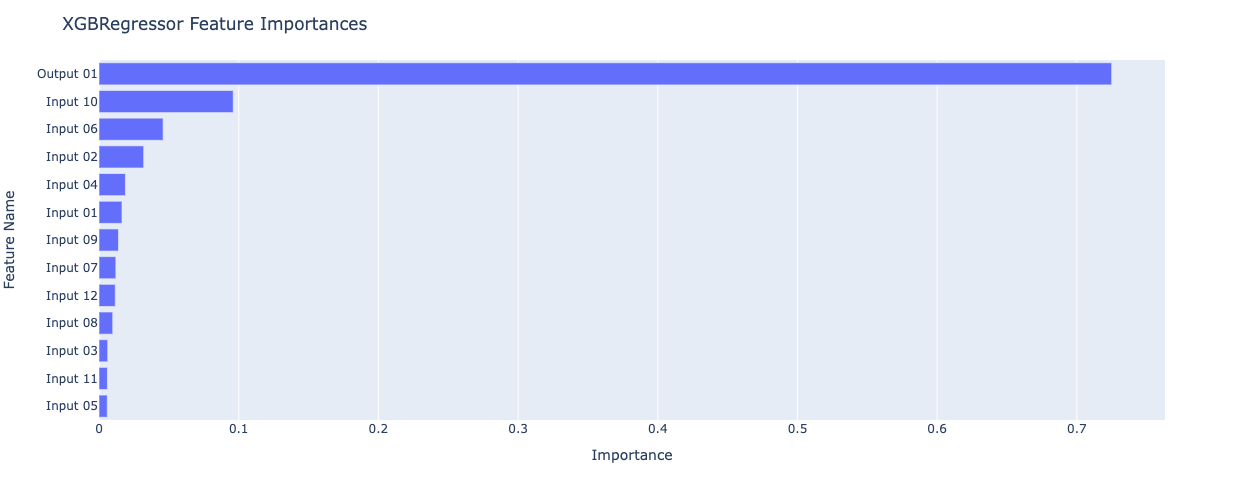

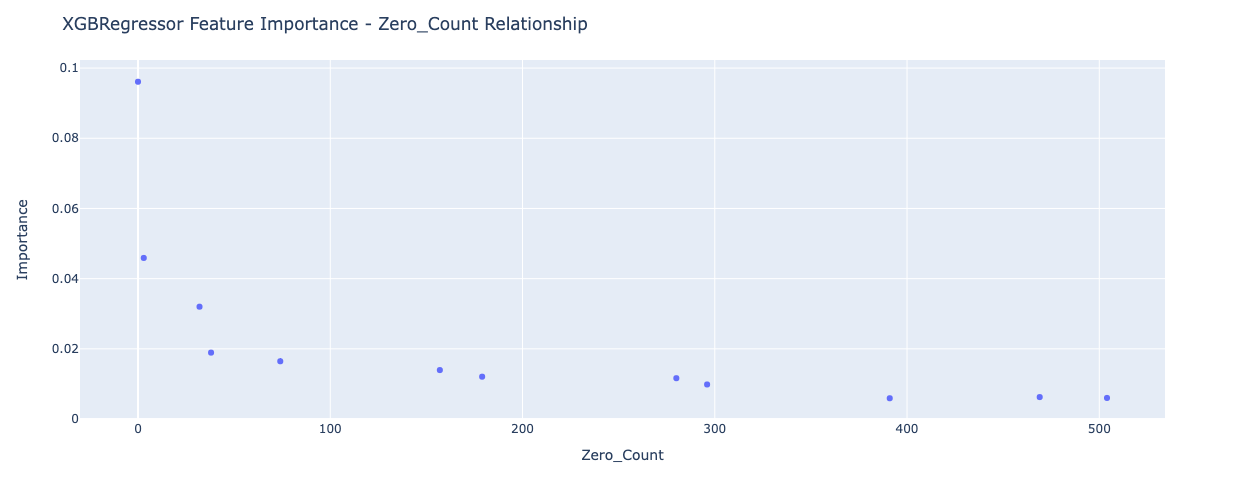

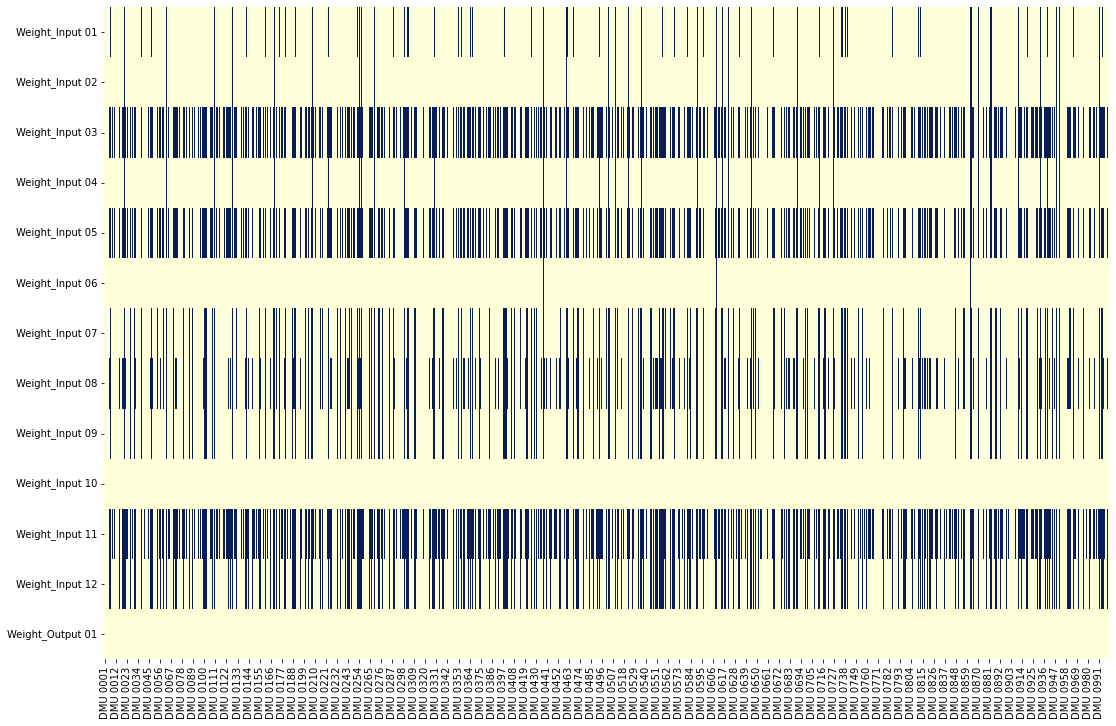

In [75]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_9.xlsx", i=i)
results.append(r)

In [76]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.666940  Output 01           0          0
1       Input 08    0.048775   Input 08         428          0
2       Input 01    0.047104   Input 01         330          0
3       Input 09    0.037908   Input 09         599          0
4       Input 06    0.029872   Input 06         396          0
..           ...         ...        ...         ...        ...
125     Input 12    0.011634   Input 12         280          9
126     Input 08    0.009847   Input 08         296          9
127     Input 03    0.006252   Input 03         469          9
128     Input 11    0.006006   Input 11         504          9
129     Input 05    0.005920   Input 05         391          9

[130 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6026  0.6744 -0.0718    -10.6421           False
1        0.6029  0.6246 -0.0217     -3.4671           False
2        0.7809  0.7774  0.0034      0.4391            True
3        0.7942  0.7629  0.0313      4.1079           False
4        0.6129  0.6209 -0.0080     -1.2912            True
..          ...     ...     ...         ...             ...
195      0.5923  0.5937 -0.0014     -0.2350            True
196      0.7909  0.7655  0.0253      3.3057           False
197      0.7527  0.7461  0.0066      0.8795            True
198      0.7033  0.7276 -0.0242     -3.3314           False
199      0.6530  0.6580 -0.0050     -0.7662            True

[200 rows x 5 columns]
blue:  114
red:  86
rho: 0.982
p-Value 0.0


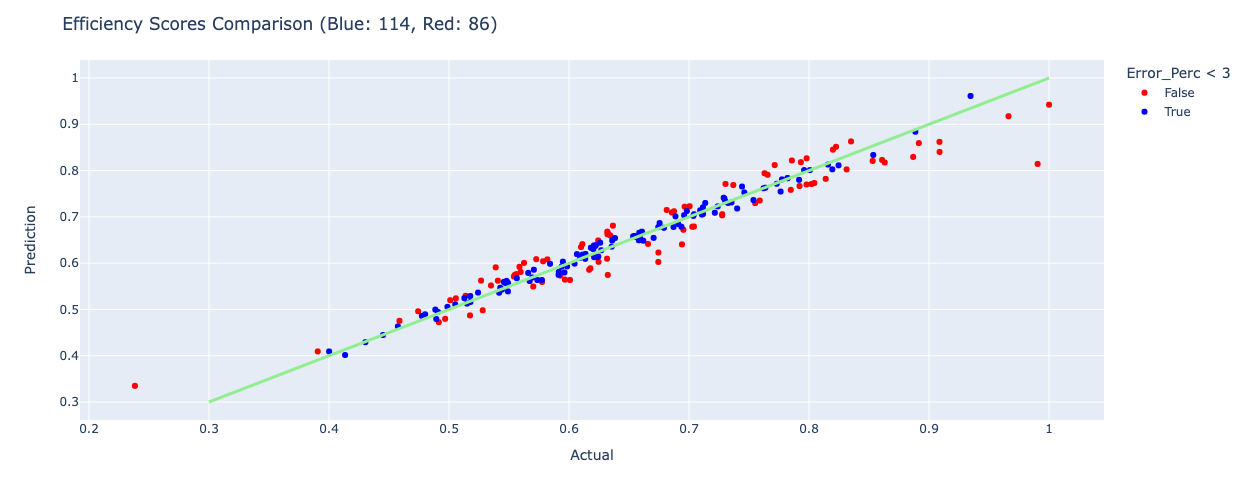

In [77]:
compareML(pipe_xgb, y)

blue :  108
red :  892


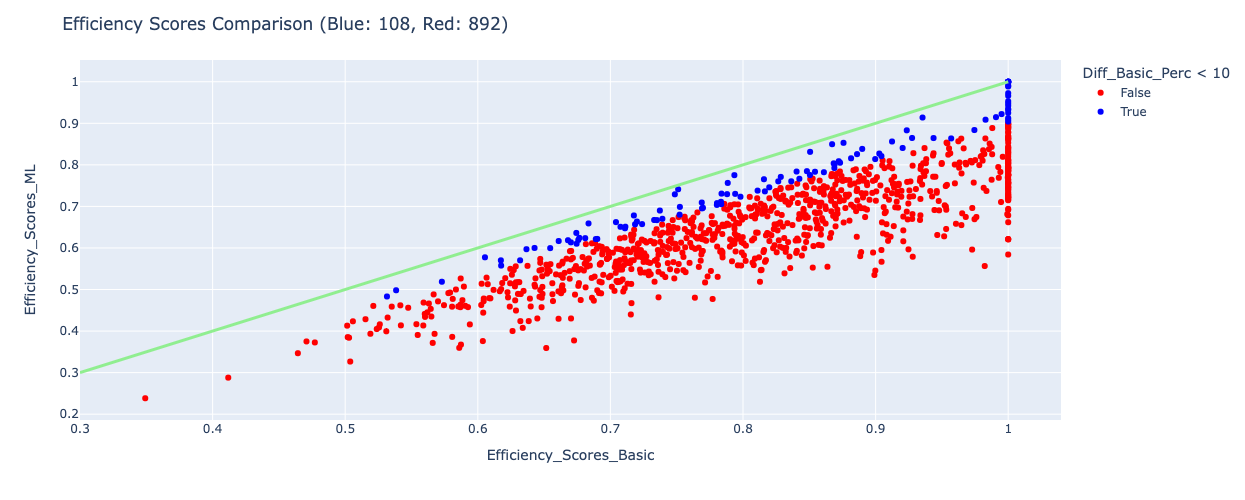

blue :  1000
red :  0


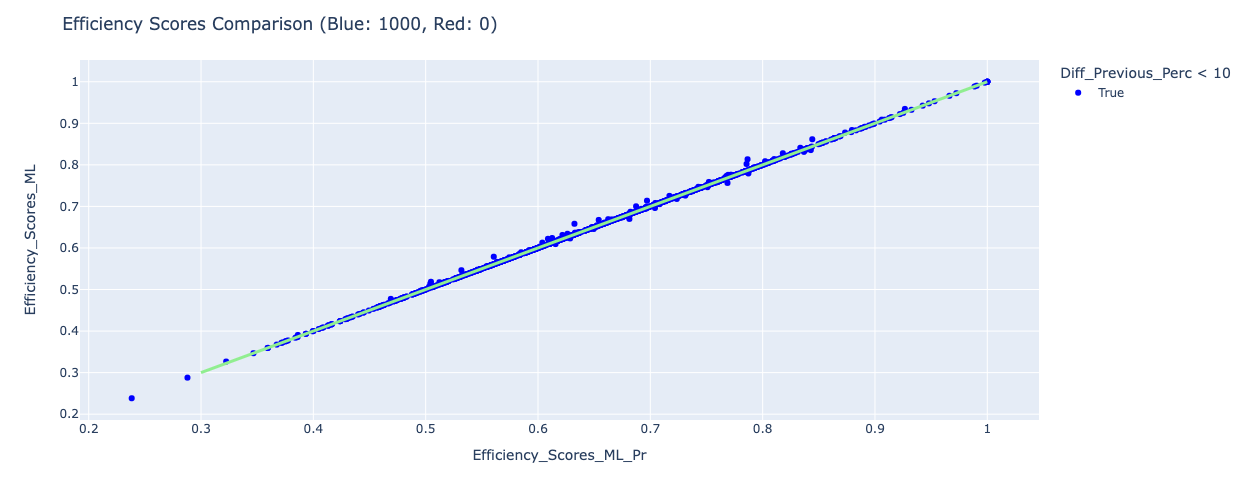

In [78]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_9.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_8.xlsx")

### i = 10

In [79]:
i +=1
i

10

In [80]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01      70
Weight_Input 02      30
Weight_Input 03     313
Weight_Input 04      37
Weight_Input 05     532
Weight_Input 06       2
Weight_Input 07     159
Weight_Input 08     243
Weight_Input 09     144
Weight_Input 10       0
Weight_Input 11     335
Weight_Input 12     233
Weight_Output 01      0
dtype: int64
Total Zeros:  2098
neg_mean_squared_error: -0.0006272882463376154
neg_root_mean_squared_error: -0.024958520900722647
r2: 0.9576223784268938
grid.best_score:  -0.024591879479210564
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.79999999999999

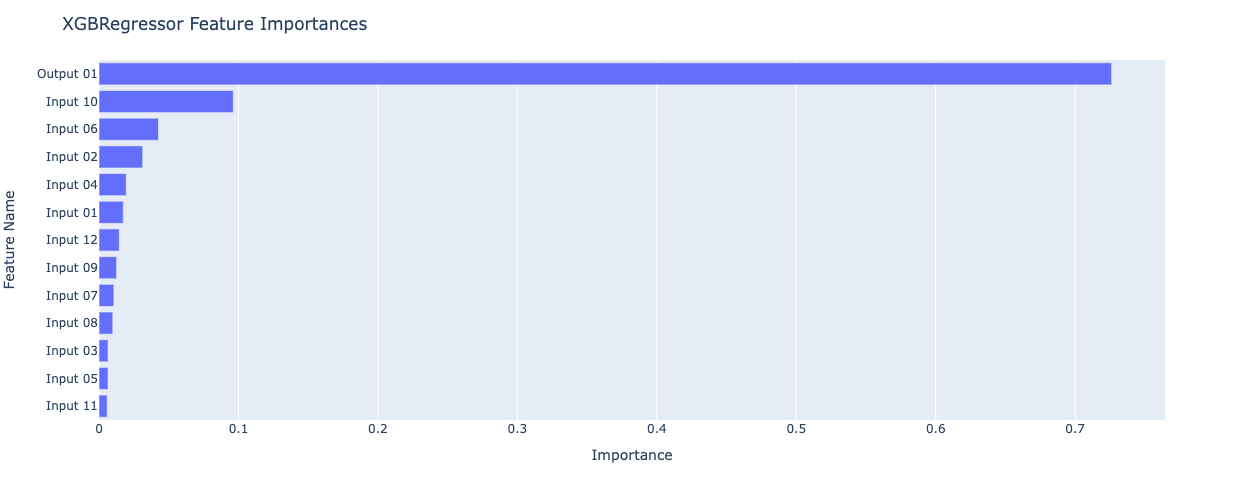

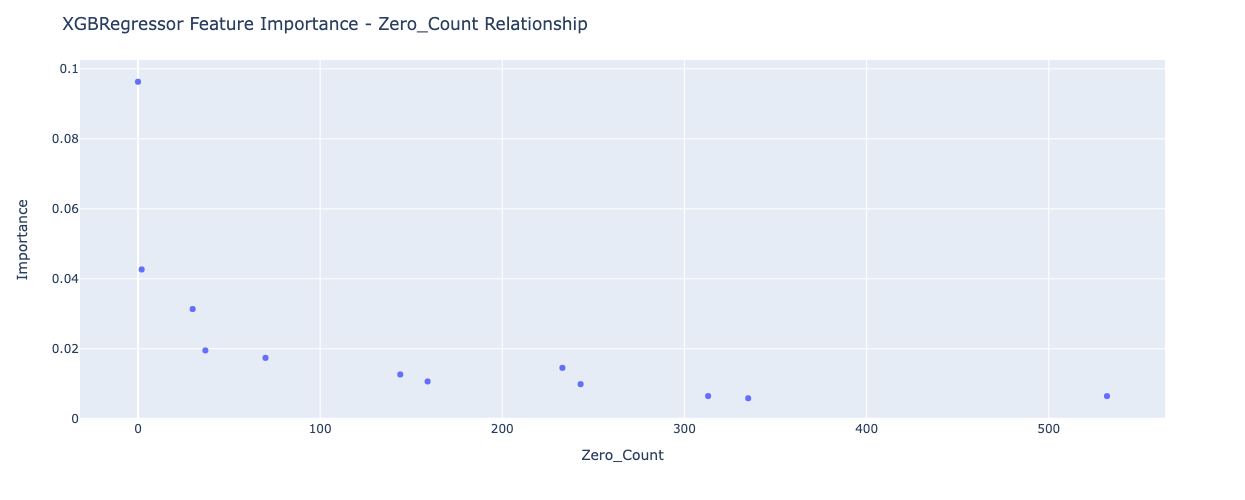

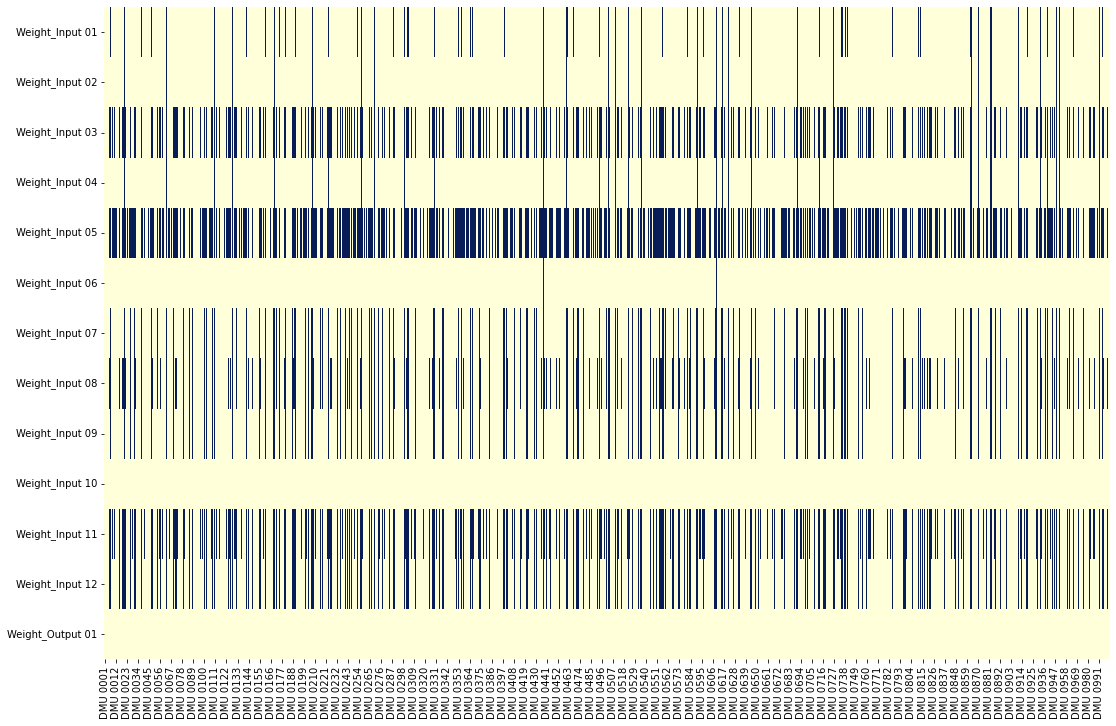

In [81]:
pipe_xgb, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_xgbregressor_Sol_10.xlsx", i=i)
results.append(r)

In [82]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.666940  Output 01           0          0
1       Input 08    0.048775   Input 08         428          0
2       Input 01    0.047104   Input 01         330          0
3       Input 09    0.037908   Input 09         599          0
4       Input 06    0.029872   Input 06         396          0
..           ...         ...        ...         ...        ...
138     Input 07    0.010661   Input 07         159         10
139     Input 08    0.009881   Input 08         243         10
140     Input 03    0.006488   Input 03         313         10
141     Input 05    0.006474   Input 05         532         10
142     Input 11    0.005861   Input 11         335         10

[143 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6036  0.6744 -0.0708    -10.4945           False
1        0.6393  0.6246  0.0147      2.3591            True
2        0.7849  0.7774  0.0074      0.9541            True
3        0.8038  0.7629  0.0409      5.3663           False
4        0.6087  0.6209 -0.0123     -1.9759            True
..          ...     ...     ...         ...             ...
195      0.5842  0.5937 -0.0095     -1.5964            True
196      0.8174  0.7652  0.0522      6.8251           False
197      0.7480  0.7461  0.0019      0.2543            True
198      0.7068  0.7276 -0.0208     -2.8539            True
199      0.6615  0.6580  0.0035      0.5273            True

[200 rows x 5 columns]
blue:  127
red:  73
rho: 0.9819
p-Value 0.0


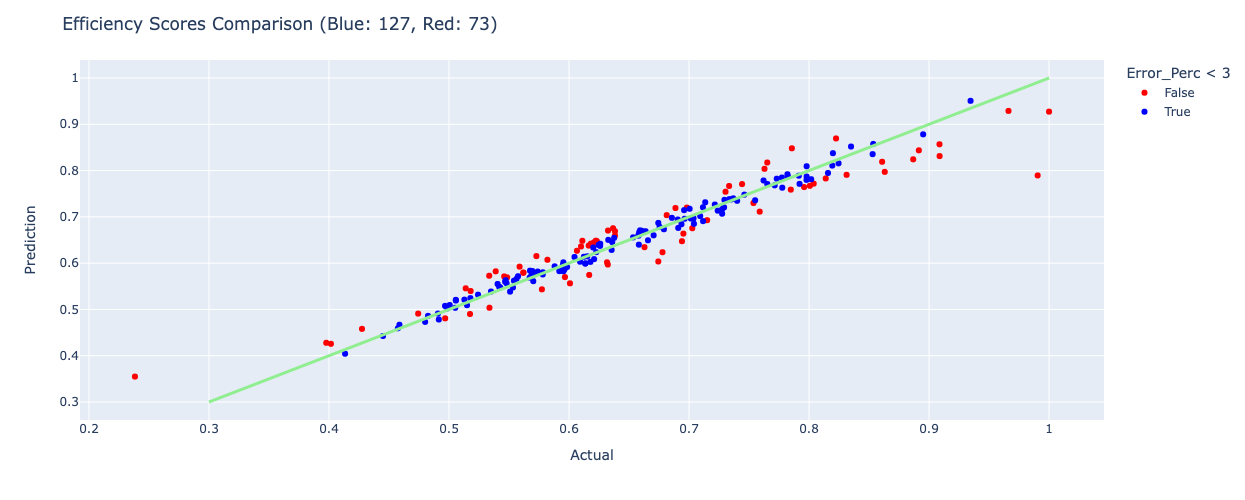

In [83]:
compareML(pipe_xgb, y)

blue :  414
red :  586


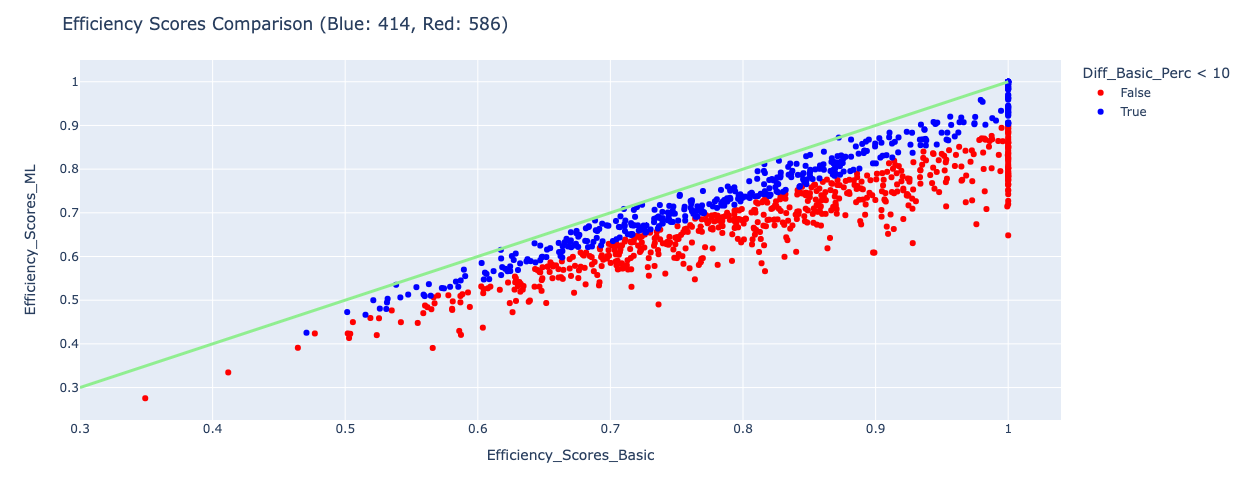

blue :  958
red :  42


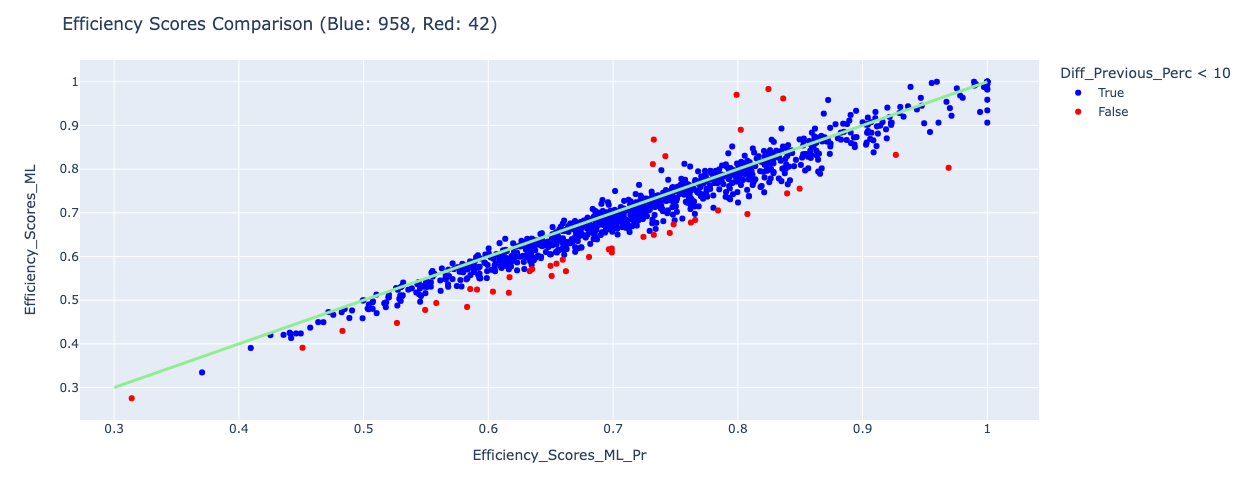

In [84]:
compareES(df_1_path="Data/Data12/US12I1O_xgbregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_xgbregressor_Sol_1.xlsx")

In [85]:
results

[(0,
  'xgbregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 06',
   'Input 07',
   'Input 03',
   'Input 10',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8975120373748599,
   'neg_root_mean_squared_error': -0.04034910223716744,
   'total_zeros': 7203}),
 (1,
  'xgbregressor',
  ['Input 08',
   'Input 10',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 07',
   'Input 02',
   'Input 12',
   'Input 05',
   'Input 09',
   'Input 11',
   'Input 04'],
  {'r2': 0.9170809217828582,
   'neg_root_mean_squared_error': -0.03262435891479705,
   'total_zeros': 3318}),
 (2,
  'xgbregressor',
  ['Input 10',
   'Input 08',
   'Input 06',
   'Input 01',
   'Input 02',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 12',
   'Input 11',
   'Input 05',
   'Input 04'],
  {'r2': 0.9342649287870263,
   'neg_root_mean_squared_error': -0.03060948226575373,
   'total_zeros': 3991}),
 (3,
  'xgbregressor',
  ['Input 10',
   'Input 06',
  

In [86]:
with open('Data/Data12/XGB_result_12I1O.pkl', 'wb') as f:
    pickle.dump(results, f)

In [87]:
with open('Data/Data12/XGB_result_12I1O.pkl', 'rb') as f:
    r = pickle.load(f)

In [88]:
r

[(0,
  'xgbregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 06',
   'Input 07',
   'Input 03',
   'Input 10',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8975120373748599,
   'neg_root_mean_squared_error': -0.04034910223716744,
   'total_zeros': 7203}),
 (1,
  'xgbregressor',
  ['Input 08',
   'Input 10',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 07',
   'Input 02',
   'Input 12',
   'Input 05',
   'Input 09',
   'Input 11',
   'Input 04'],
  {'r2': 0.9170809217828582,
   'neg_root_mean_squared_error': -0.03262435891479705,
   'total_zeros': 3318}),
 (2,
  'xgbregressor',
  ['Input 10',
   'Input 08',
   'Input 06',
   'Input 01',
   'Input 02',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 12',
   'Input 11',
   'Input 05',
   'Input 04'],
  {'r2': 0.9342649287870263,
   'neg_root_mean_squared_error': -0.03060948226575373,
   'total_zeros': 3991}),
 (3,
  'xgbregressor',
  ['Input 10',
   'Input 06',
  

In [89]:
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.666940  Output 01           0          0
1       Input 08    0.048775   Input 08         428          0
2       Input 01    0.047104   Input 01         330          0
3       Input 09    0.037908   Input 09         599          0
4       Input 06    0.029872   Input 06         396          0
..           ...         ...        ...         ...        ...
138     Input 07    0.010661   Input 07         159         10
139     Input 08    0.009881   Input 08         243         10
140     Input 03    0.006488   Input 03         313         10
141     Input 05    0.006474   Input 05         532         10
142     Input 11    0.005861   Input 11         335         10

[143 rows x 5 columns]

In [90]:
df_imp.Iteration.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [91]:
df_imp.to_pickle('Data/Data12/XGB_12I1O_df_imp.pkl')